In [1]:
cd ..

/Users/sethhendrickson/cbbmodel


In [2]:
import pandas as pd
import pymc
import numpy as np
from DB import DB
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_season(dt):
    year = dt.year
    month = dt.month
    if month > 6:
        return year + 1
    else:
        return year

In [4]:
# box = pd.read_sql("SELECT * FROM box_test WHERE first_name='Totals'", DB.conn)
games = pd.read_sql("SELECT * FROM games_test", DB.conn)
games['season']  = games.dt.map(lambda d: get_season(d))
games = games[games.season == 2015]
print games.shape

(5926, 12)


In [17]:
hteams = games[['hteam_id']]
ateams = games[['ateam_id']]
hteams = hteams.rename(columns={'hteam_id': 'team_id'})
ateams = ateams.rename(columns={'ateam_id': 'team_id'})
teams = pd.concat([hteams, ateams], axis=0)
teams.drop_duplicates(inplace=True)
print teams.shape
teams = teams.reset_index()
teams['iteam'] = teams.index.values
teams.drop('index', 1, inplace=True)
print teams.head(), teams.shape

(518, 1)
   team_id  iteam
0       86      0
1      295      1
2      649      2
3      609      3
4      731      4 (518, 2)


In [6]:
games = games.merge(teams, left_on='hteam_id', right_on='team_id', how='left')
games = games.rename(columns={'iteam': 'i_home'})
games.drop('team_id', 1, inplace=True)
games = games.merge(teams, left_on='ateam_id', right_on='team_id', how='left')
games = games.rename(columns={'iteam': 'i_away'})
games.drop('team_id', 1, inplace=True)
print games.shape

(5926, 14)


In [7]:
num_teams = teams.shape[0]
print num_teams

518


In [8]:
observed_home_goals = games.home_score.values
observed_away_goals = games.away_score.values
home_team = games.i_home.values
away_team = games.i_away.values
num_games = len(home_team)
print home_team.shape, observed_away_goals.shape

(5926,) (5926,)


In [9]:
hteam = games[['hteam_id', 'home_score', 'away_score', 'i_home']]
hteam = hteam.rename(columns={'hteam_id': 'team_id', 'home_score': 'pts_scored', 'away_score': 'pts_allowed', 'i_home': 'i'})
ateam = games[['ateam_id', 'home_score', 'away_score', 'i_away']]
ateam = ateam.rename(columns={'ateam_id': 'team_id', 'away_score': 'pts_scored', 'home_score': 'pts_allowed', 'i_away': 'i'})
priors = pd.concat([hteam, ateam], axis=0)
g = priors.groupby('i')
att_starting_points = np.log(g.pts_scored.mean())
def_starting_points = -np.log(g.pts_allowed.mean())
# print np.exp(att_starting_points)

In [10]:
g.count()
print np.min(att_starting_points), np.max(att_starting_points)

3.36729582999 4.44265125649


In [11]:
# home = pymc.Normal('home', 0., 1 / 5.**2)#, value=6.)
# tau_att = pymc.Uniform('tau_att', 0., 1.)#, value=0.001)
# tau_def = pymc.Uniform('tau_def', 0., 1.)#, value=0.001)
# intercept = pymc.Normal('intercept', 0., 10., value=0)
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', 0.1, .1, value=1)
tau_def = pymc.Gamma('tau_def', 0.1, .1, value=1)
intercept = pymc.Normal('intercept', 0, .0001, value=0)
atts_star = pymc.Normal("atts_star", 
                        mu=5, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=5, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values)

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs,
              intercept=intercept): 
    return np.exp(intercept + home + atts[home_team] + defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs,
              intercept=intercept): 
    return np.exp(intercept + atts[away_team] + defs[home_team])


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

model = pymc.Model([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
mcmc = pymc.MCMC(model)
mcmc.sample(100000, 30000)

 [-----------------100%-----------------] 100000 of 100000 complete in 173.5 sec

In [12]:
home_theta.stats()['mean']

array([ 77.20544972,  72.85762704,  79.91107108, ...,  64.02998844,
        84.72151546,  84.05203862])

In [15]:
atts = atts.stats()['mean']

In [21]:
post_teams = teams
post_teams['atts'] = atts
post_teams.head()

team_id 
 iteam 
 atts 
 
 
 
 
 0 
 86 
 0 
 0.182630 
 
 
 1 
 295 
 1 
 0.124675 
 
 
 2 
 649 
 2 
 0.112987 
 
 
 3 
 609 
 3 
 -0.033893 
 
 
 4 
 731 
 4 
 0.065540

In [41]:
all_teams = pd.read_sql("SELECT ncaaid, team_name FROM teams", DB.conn)
print all_teams.shape
merged = post_teams.merge(all_teams, how='left', left_on='team_id', right_on='ncaaid')
merged.head()

(364, 2)


team_id 
 iteam 
 atts 
 ncaaid 
 team_name 
 
 
 
 
 0 
 86 
 0 
 0.182630 
 86 
 Buffalo 
 
 
 1 
 295 
 1 
 0.124675 
 295 
 Idaho 
 
 
 2 
 649 
 2 
 0.112987 
 649 
 S Dakota St 
 
 
 3 
 609 
 3 
 -0.033893 
 609 
 St Louis 
 
 
 4 
 731 
 4 
 0.065540 
 731 
 Utah St

In [45]:
merged.sort('atts', ascending=False)

team_id 
 iteam 
 atts 
 ncaaid 
 team_name 
 
 
 
 
 417 
 224 
 404 
 0.341782 
 NaN 
 NaN 
 
 
 503 
 12399 
 490 
 0.326627 
 NaN 
 NaN 
 
 
 224 
 77 
 211 
 0.306636 
 77 
 BYU 
 
 
 253 
 457 
 240 
 0.295595 
 457 
 North Carolina 
 
 
 258 
 193 
 245 
 0.288380 
 193 
 Duke 
 
 
 128 
 311 
 115 
 0.269131 
 311 
 Iowa St 
 
 
 452 
 30138 
 439 
 0.267562 
 NaN 
 NaN 
 
 
 491 
 477 
 478 
 0.263758 
 NaN 
 NaN 
 
 
 181 
 513 
 168 
 0.257690 
 513 
 Notre Dame 
 
 
 64 
 306 
 51 
 0.253195 
 306 
 Indiana 
 
 
 52 
 31 
 39 
 0.249962 
 31 
 Arkansas 
 
 
 17 
 260 
 17 
 0.242274 
 260 
 Gonzaga 
 
 
 247 
 173 
 234 
 0.240058 
 173 
 Davidson 
 
 
 322 
 29 
 309 
 0.236878 
 29 
 Arizona 
 
 
 230 
 310 
 217 
 0.236606 
 310 
 Iona 
 
 
 252 
 739 
 239 
 0.229490 
 739 
 Villanova 
 
 
 254 
 334 
 241 
 0.225951 
 334 
 Kentucky 
 
 
 294 
 518 
 281 
 0.221792 
 518 
 Ohio St 
 
 
 225 
 328 
 212 
 0.220627 
 328 
 Kansas 
 
 
 72 
 741 
 59 
 0.217914 
 741 
 VMI 
 
 
 529 
 435 
 516 
 0.217889 
 NaN 
 NaN 
 
 
 144 
 812 
 131 
 0.217710 
 812 
 Xavier 
 
 
 141 
 796 
 128 
 0.216391 
 796 
 Wisconsin 
 
 
 396 
 30045 
 383 
 0.215282 
 NaN 
 NaN 
 
 
 107 
 428 
 94 
 0.210546 
 428 
 Minnesota 
 
 
 34 
 508 
 34 
 0.209364 
 508 
 Northwestern LA 
 
 
 91 
 768 
 78 
 0.204878 
 768 
 West Virginia 
 
 
 162 
 454 
 149 
 0.200947 
 454 
 Murray St 
 
 
 472 
 30047 
 459 
 0.198303 
 NaN 
 NaN 
 
 
 312 
 529 
 299 
 0.197727 
 529 
 Oregon 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 411 
 259 
 398 
 -0.300232 
 NaN 
 NaN 
 
 
 442 
 195 
 429 
 -0.311724 
 NaN 
 NaN 
 
 
 488 
 1278 
 475 
 -0.329771 
 NaN 
 NaN 
 
 
 499 
 515 
 486 
 -0.330658 
 NaN 
 NaN 
 
 
 519 
 30164 
 506 
 -0.332746 
 NaN 
 NaN 
 
 
 399 
 12830 
 386 
 -0.339260 
 NaN 
 NaN 
 
 
 479 
 98 
 466 
 -0.346271 
 NaN 
 NaN 
 
 
 385 
 1355 
 372 
 -0.352341 
 NaN 
 NaN 
 
 
 498 
 1347 
 485 
 -0.354266 
 NaN 
 NaN 
 
 
 436 
 985 
 423 
 -0.363337 
 NaN 
 NaN 
 
 
 465 
 722 
 452 
 -0.385986 
 NaN 
 NaN 
 
 
 410 
 30065 
 397 
 -0.387979 
 NaN 
 NaN 
 
 
 501 
 568 
 488 
 -0.393595 
 NaN 
 NaN 
 
 
 454 
 524 
 441 
 -0.408609 
 NaN 
 NaN 
 
 
 510 
 573 
 497 
 -0.409061 
 NaN 
 NaN 
 
 
 513 
 566 
 500 
 -0.409955 
 NaN 
 NaN 
 
 
 482 
 30081 
 469 
 -0.423667 
 NaN 
 NaN 
 
 
 481 
 221 
 468 
 -0.430178 
 NaN 
 NaN 
 
 
 530 
 30120 
 517 
 -0.445908 
 NaN 
 NaN 
 
 
 439 
 134 
 426 
 -0.467652 
 NaN 
 NaN 
 
 
 500 
 707 
 487 
 -0.469774 
 NaN 
 NaN 
 
 
 367 
 1012 
 354 
 -0.470272 
 NaN 
 NaN 
 
 
 437 
 30139 
 424 
 -0.473644 
 NaN 
 NaN 
 
 
 434 
 8366 
 421 
 -0.485145 
 NaN 
 NaN 
 
 
 423 
 2758 
 410 
 -0.499867 
 NaN 
 NaN 
 
 
 438 
 30175 
 425 
 -0.507886 
 NaN 
 NaN 
 
 
 518 
 1400 
 505 
 -0.556353 
 NaN 
 NaN 
 
 
 527 
 1297 
 514 
 -0.620204 
 NaN 
 NaN 
 
 
 524 
 341 
 511 
 -0.634006 
 NaN 
 NaN 
 
 
 416 
 30170 
 403 
 -0.716327 
 NaN 
 NaN 
 
 
 
 531 rows × 5 columns

In [32]:
games.head()

dt 
 hteam_id 
 ateam_id 
 home_score 
 away_score 
 neutral 
 neutral_site 
 home_outcome 
 numot 
 game_id 
 opp_string 
 season 
 i_home 
 i_away 
 
 
 
 
 0 
 2014-11-14 
 86 
 649 
 69 
 67 
 False 
 None 
 True 
 0 
 3506808 
 Buffalo 
 2015 
 0 
 2 
 
 
 1 
 2014-11-17 
 295 
 649 
 82 
 77 
 False 
 None 
 True 
 0 
 3512407 
 Idaho 
 2015 
 1 
 2 
 
 
 2 
 2014-11-21 
 649 
 494 
 74 
 72 
 False 
 None 
 True 
 0 
 3519406 
 North Dakota 
 2015 
 2 
 24 
 
 
 3 
 2014-11-24 
 649 
 1012 
 87 
 42 
 False 
 None 
 True 
 0 
 3521726 
 Chadron St. 
 2015 
 2 
 354 
 
 
 4 
 2014-11-30 
 649 
 28755 
 58 
 71 
 True 
 Sioux Falls S.D. (Sanford Pentagon) 
 False 
 0 
 3545511 
 FGCU 
 2015 
 2 
 144

Plotting defs_0
Plotting defs_1
Plotting defs_2
Plotting defs_3
Plotting defs_4
Plotting defs_5
Plotting defs_6
Plotting defs_7
Plotting defs_8
Plotting defs_9
Plotting defs_10
Plotting defs_11
Plotting defs_12
Plotting defs_13
Plotting defs_14
Plotting defs_15
Plotting defs_16
Plotting defs_17
Plotting defs_18
Plotting defs_19
Plotting defs_20
Plotting defs_21
Plotting defs_22
Plotting defs_23
Plotting defs_24
Plotting defs_25
Plotting defs_26
Plotting defs_27
Plotting defs_28
Plotting defs_29
Plotting defs_30
Plotting defs_31
Plotting defs_32
Plotting defs_33
Plotting defs_34
Plotting defs_35
Plotting defs_36
Plotting defs_37
Plotting defs_38
Plotting defs_39
Plotting defs_40
Plotting defs_41
Plotting defs_42
Plotting defs_43
Plotting defs_44
Plotting defs_45
Plotting defs_46
Plotting defs_47
Plotting defs_48
Plotting defs_49
Plotting defs_50
Plotting defs_51
Plotting defs_52
Plotting defs_53
Plotting defs_54
Plotting defs_55
Plotting defs_56
Plotting defs_57
Plotting defs_58
Plottin

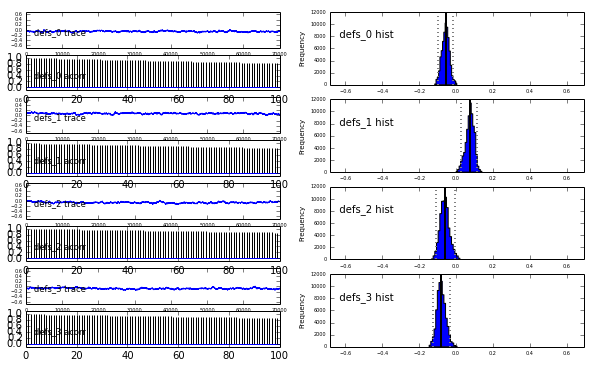

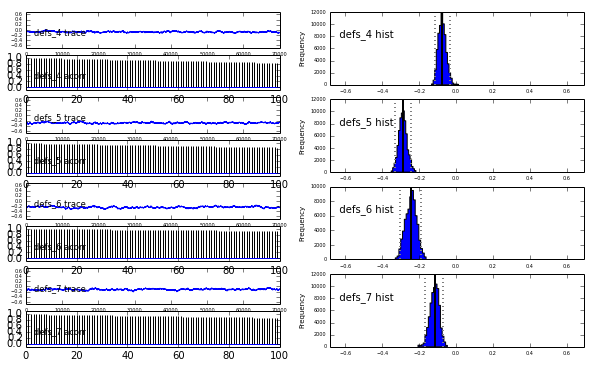

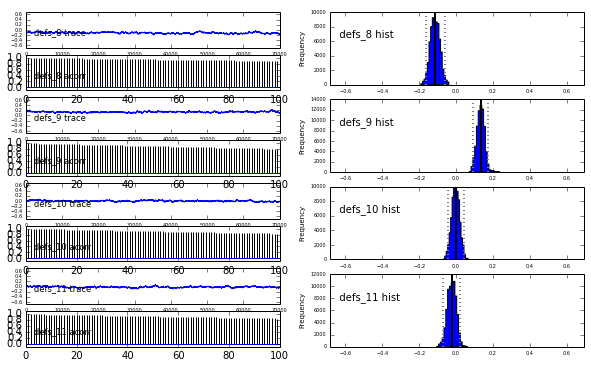

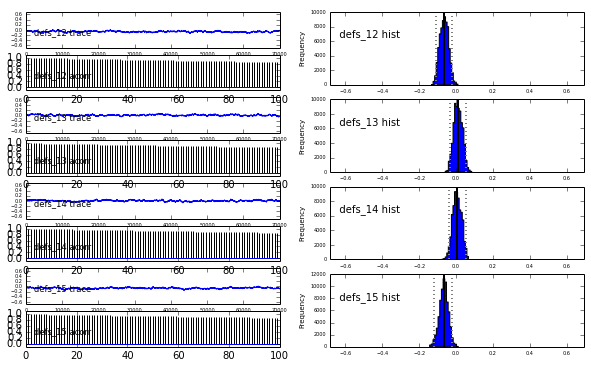

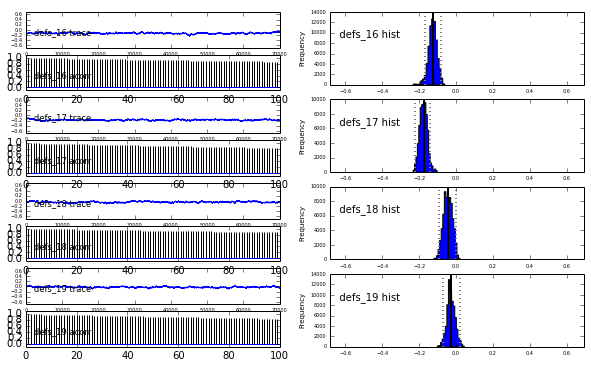

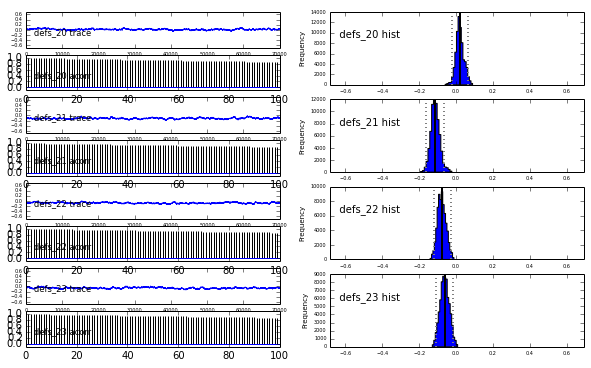

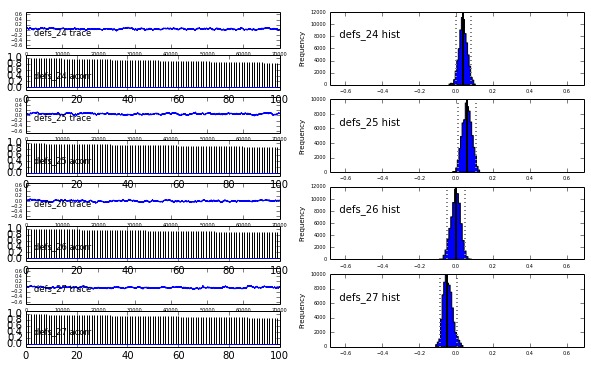

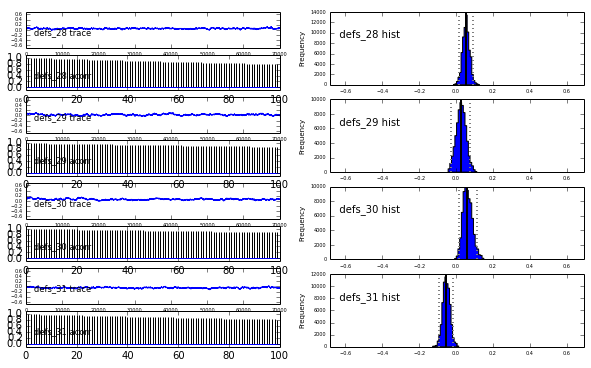

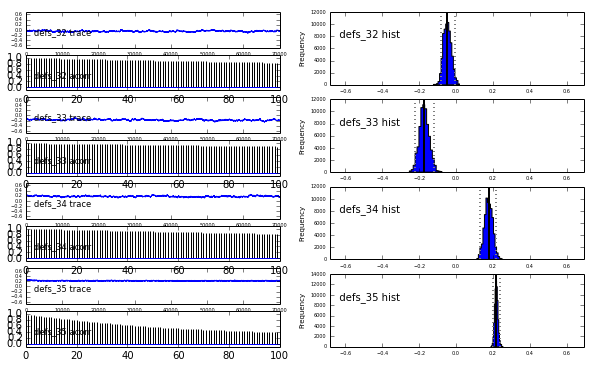

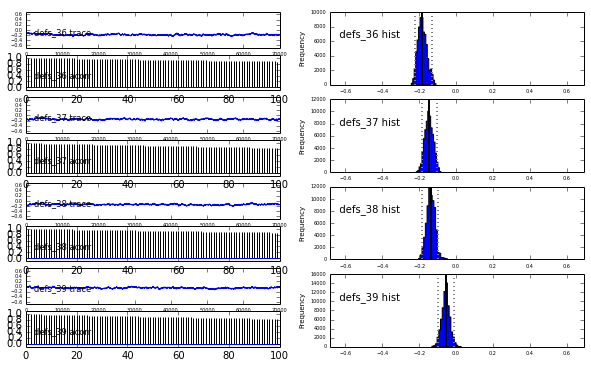

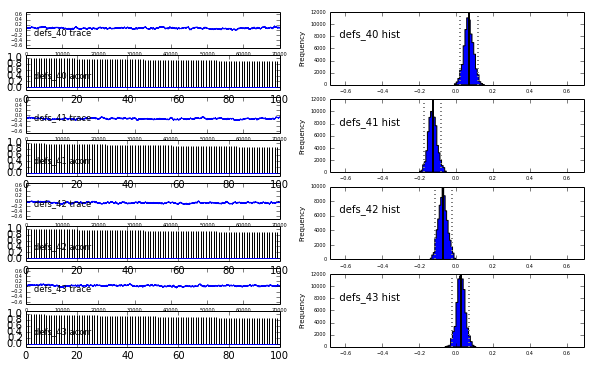

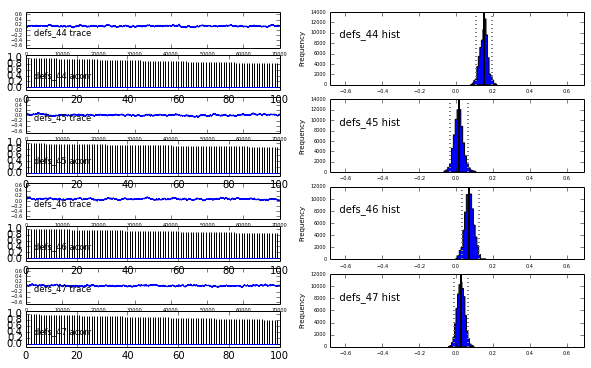

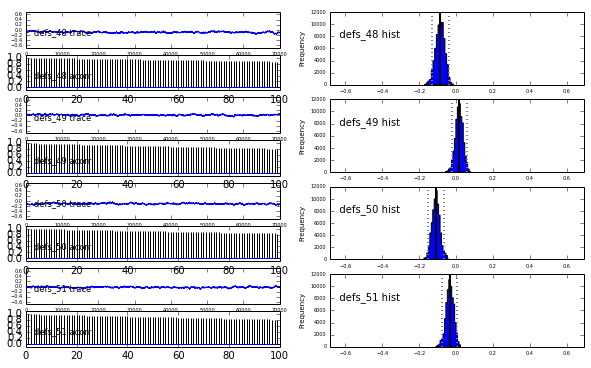

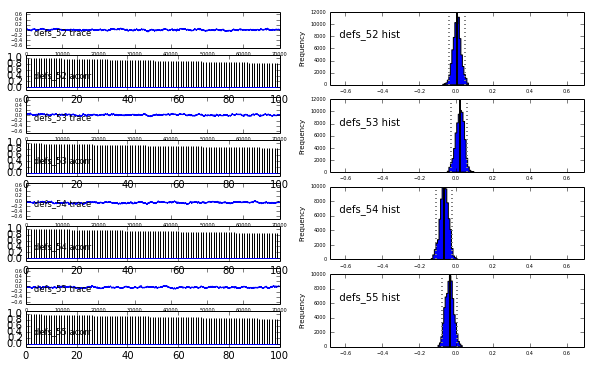

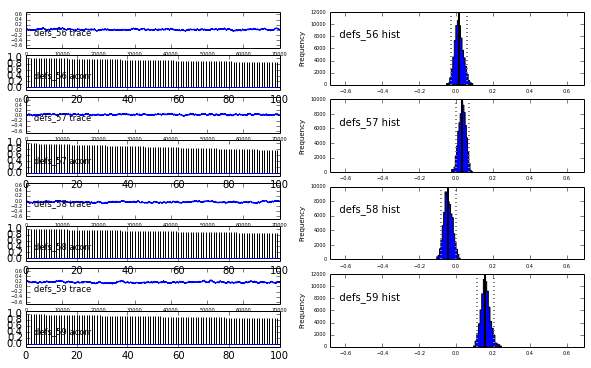

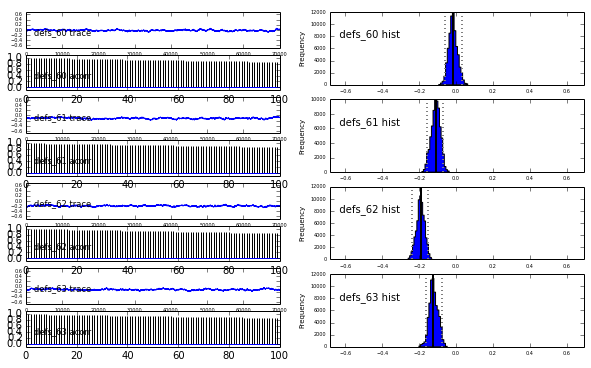

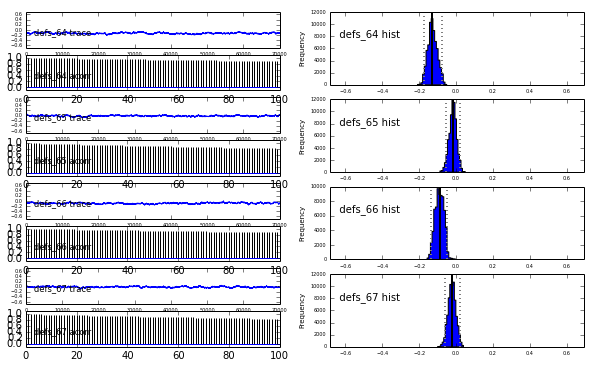

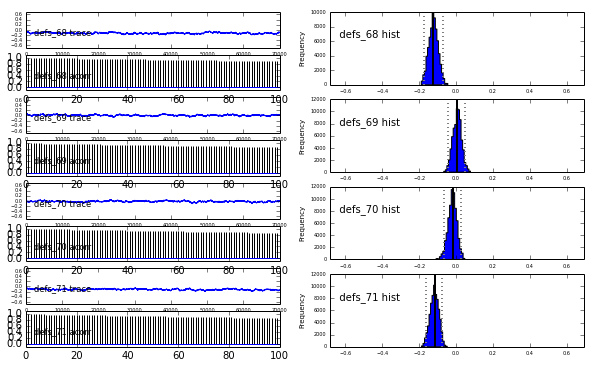

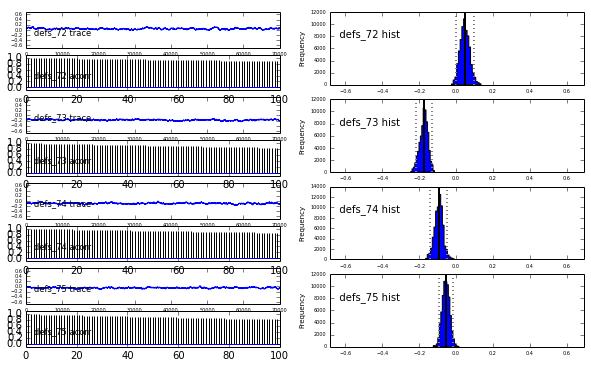

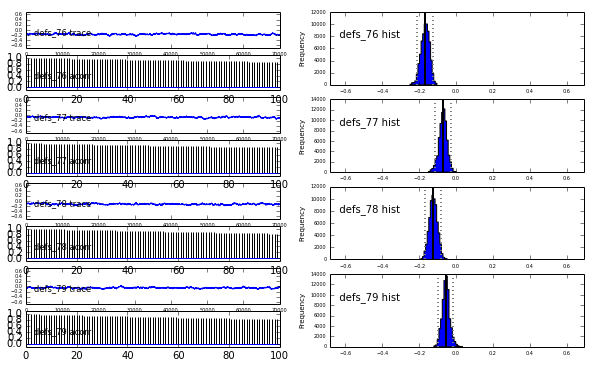

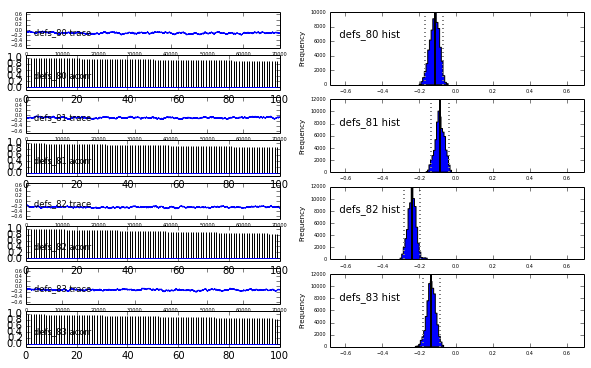

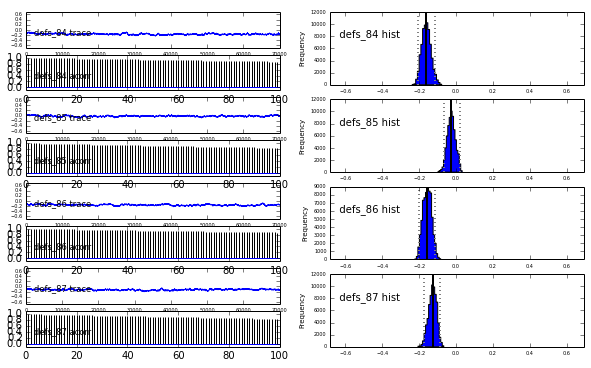

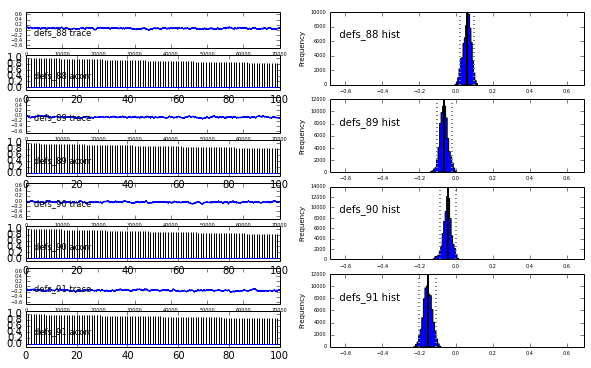

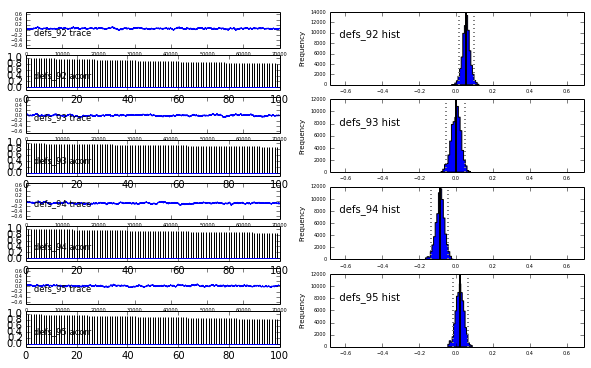

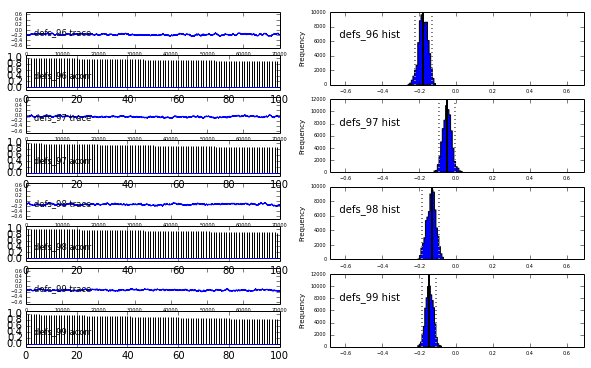

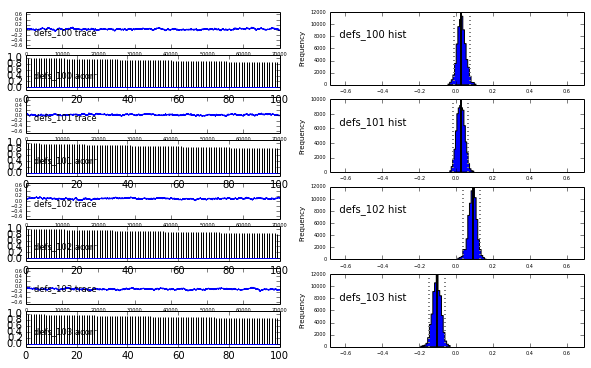

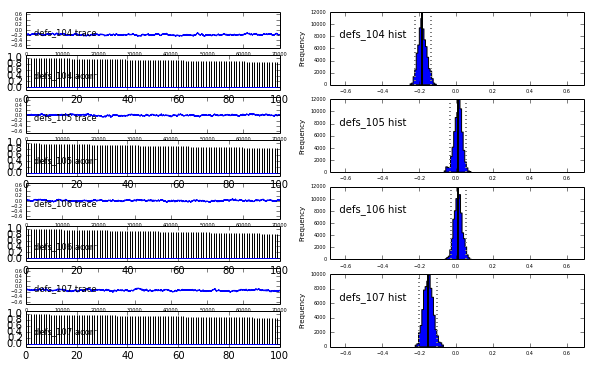

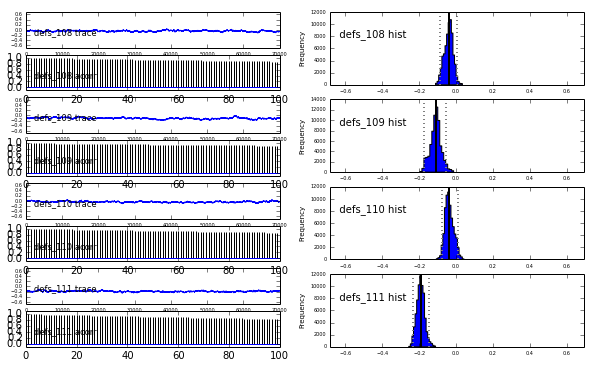

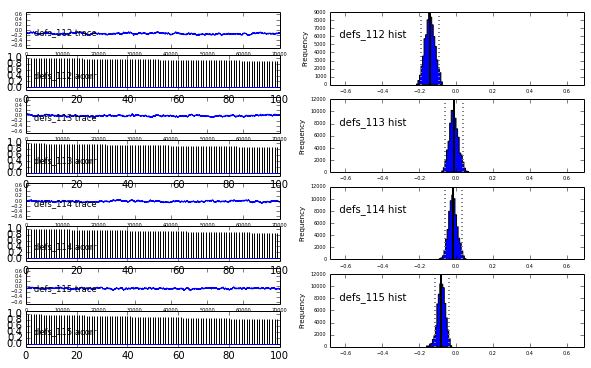

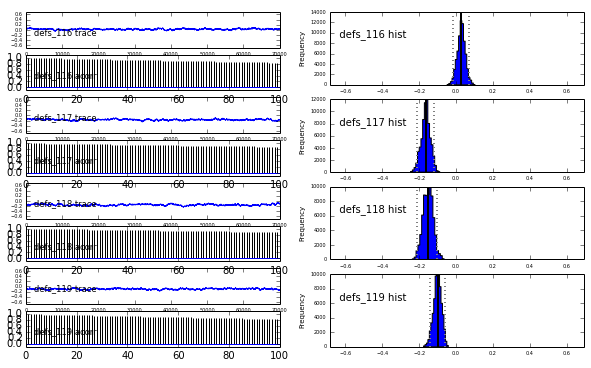

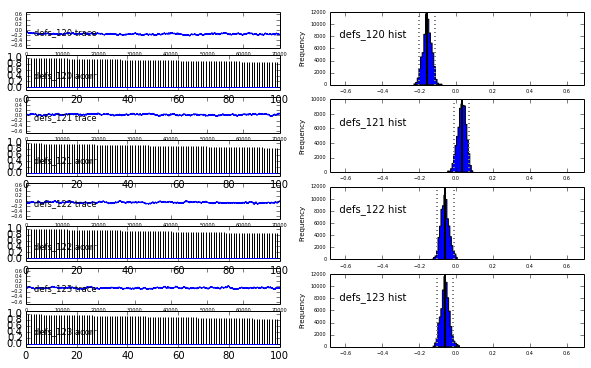

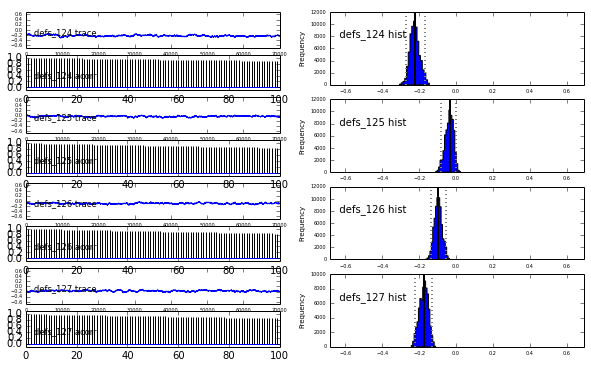

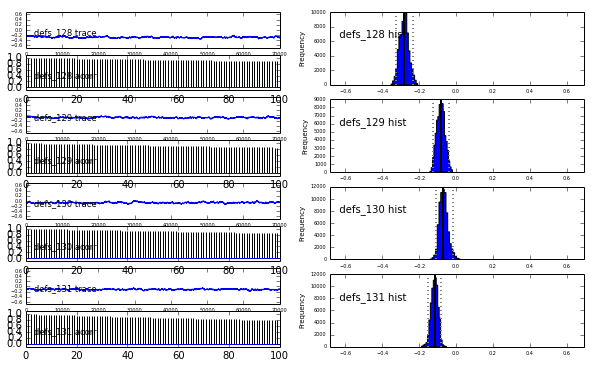

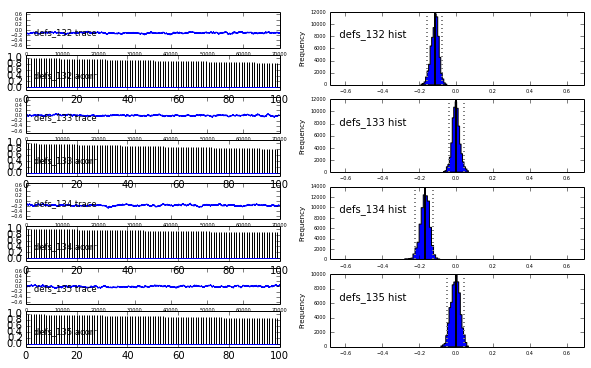

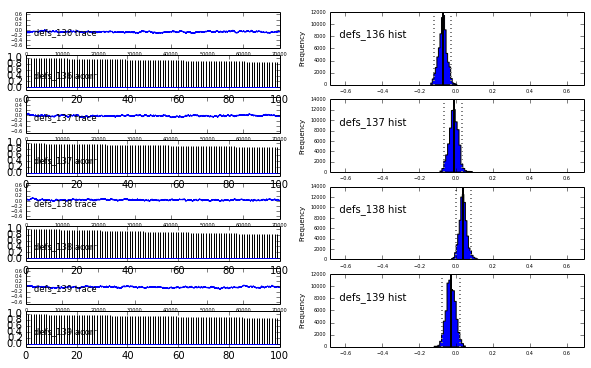

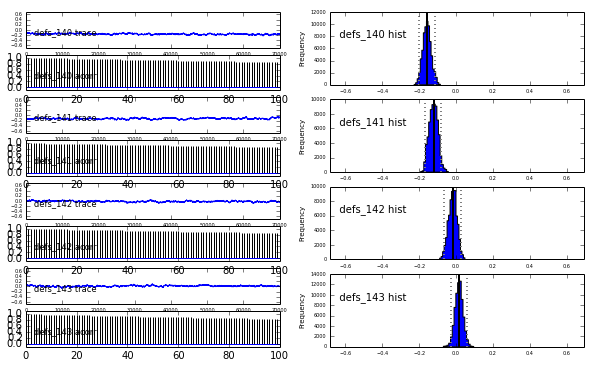

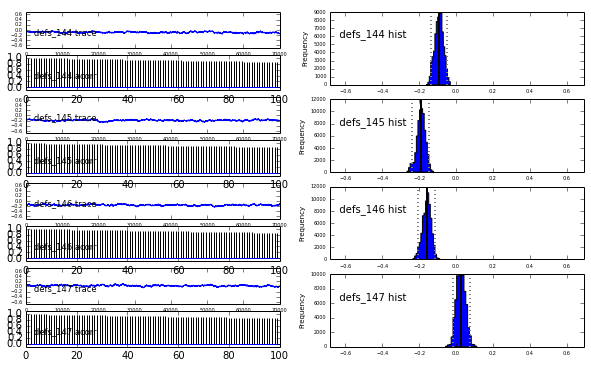

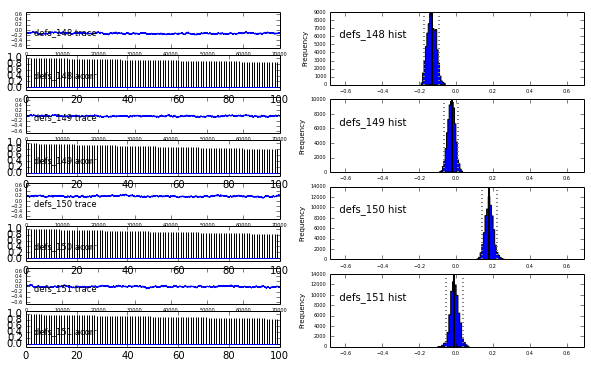

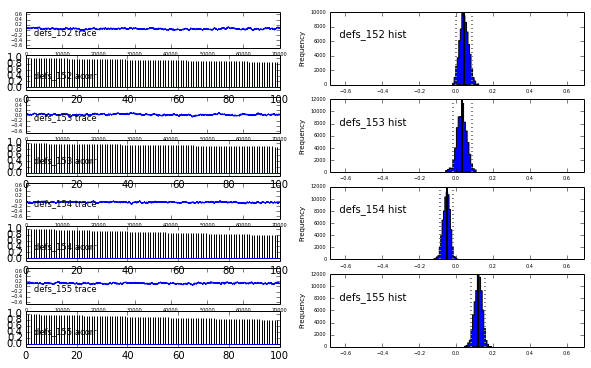

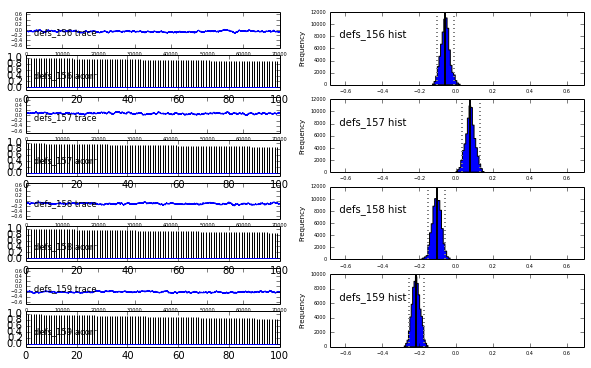

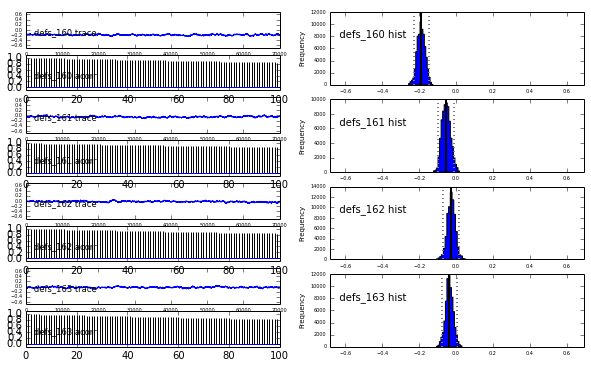

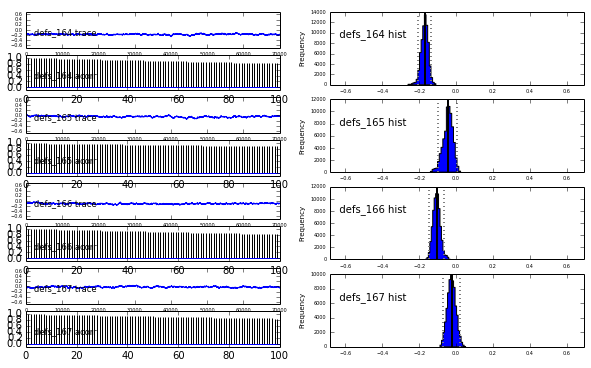

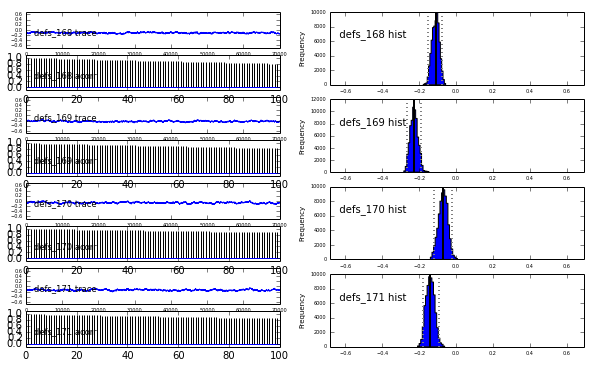

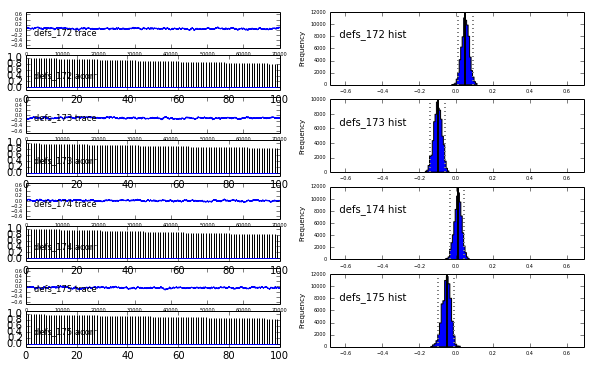

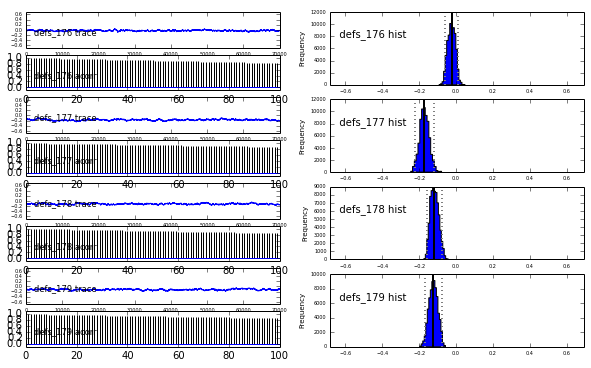

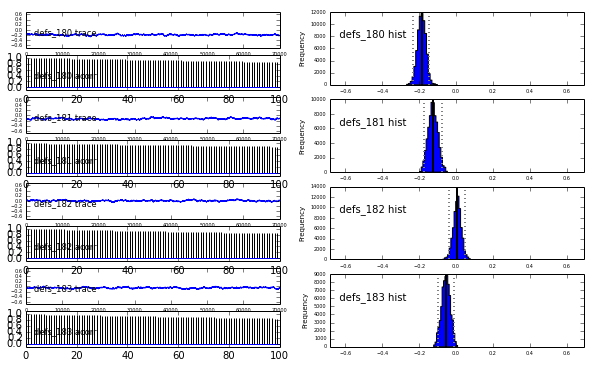

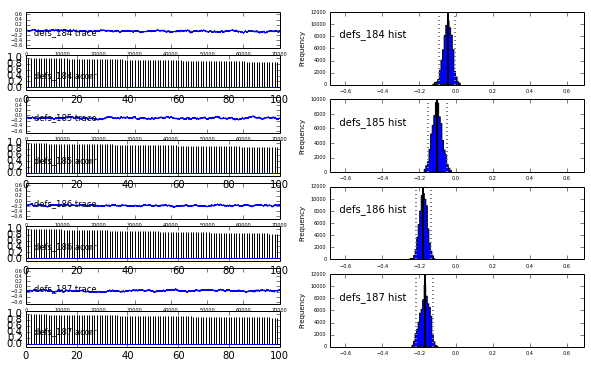

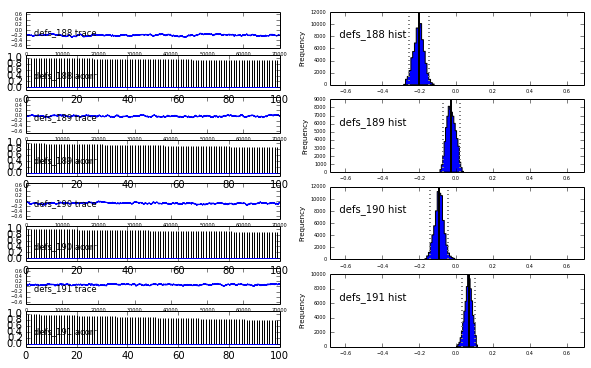

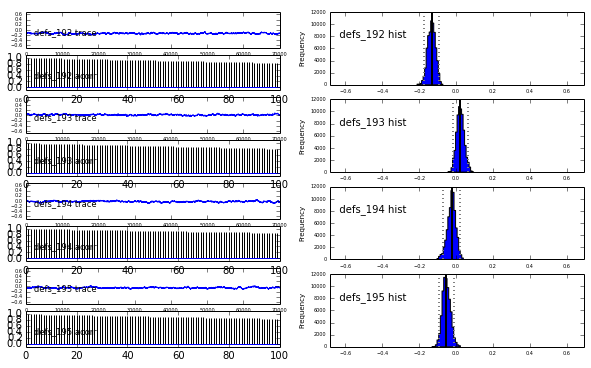

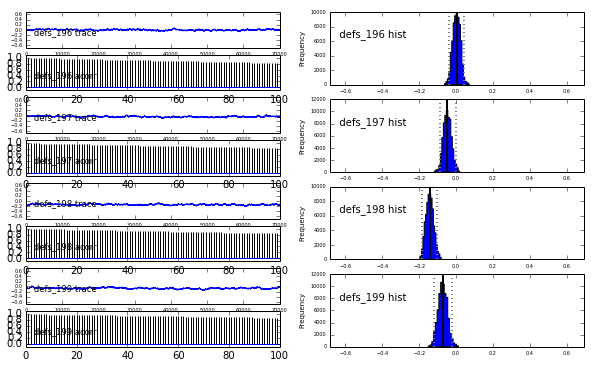

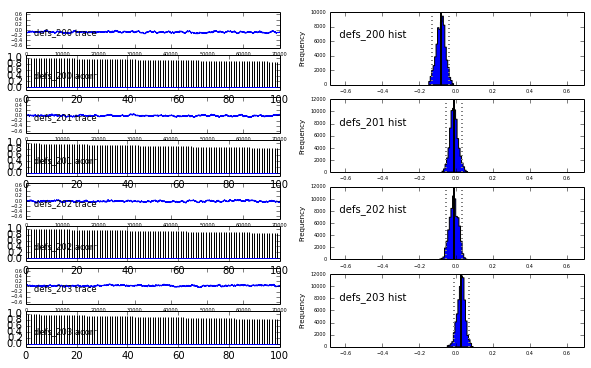

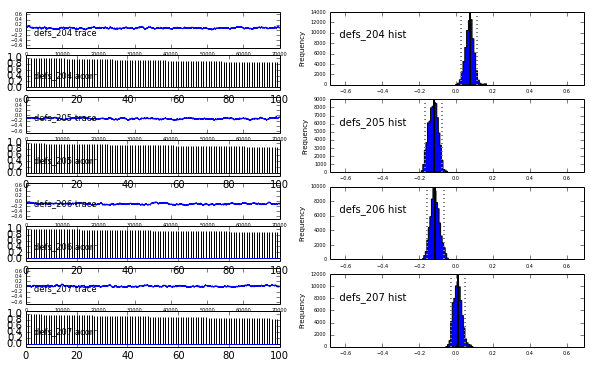

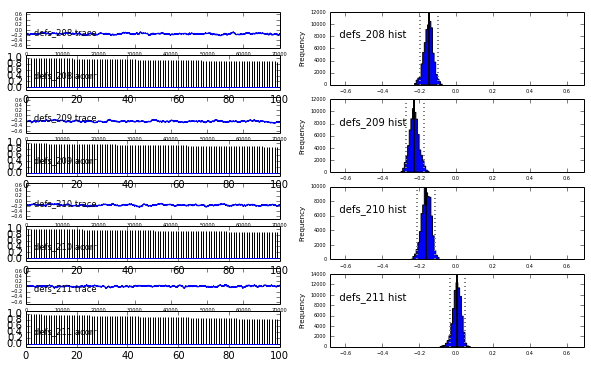

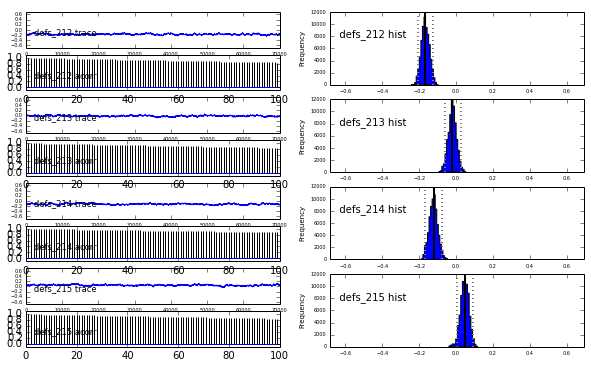

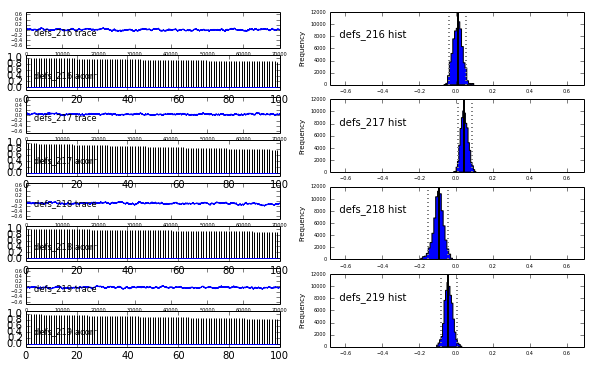

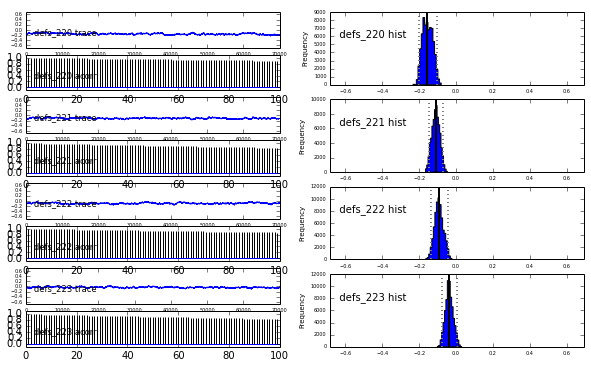

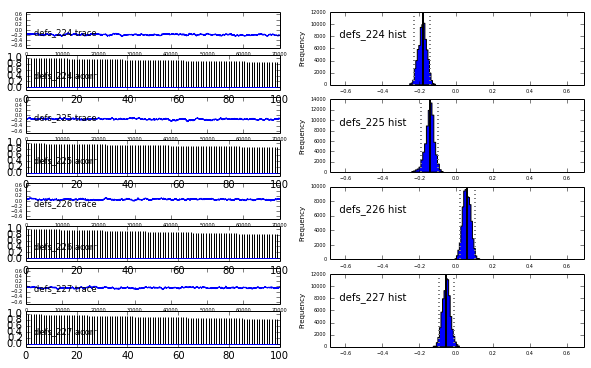

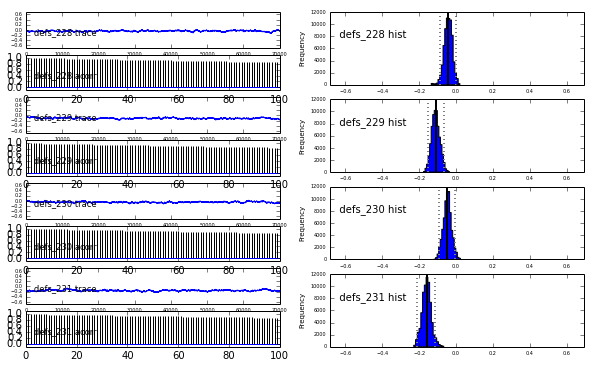

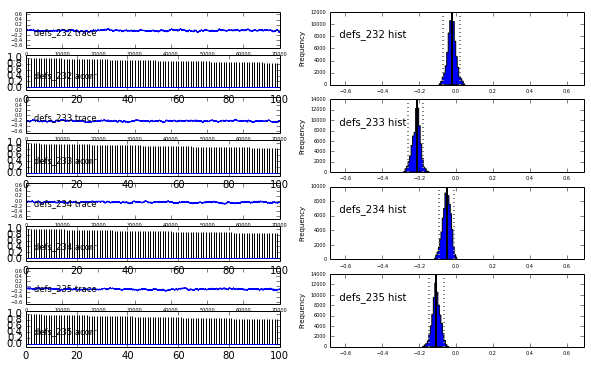

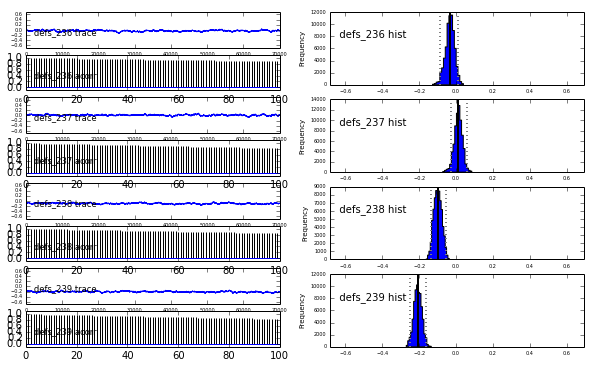

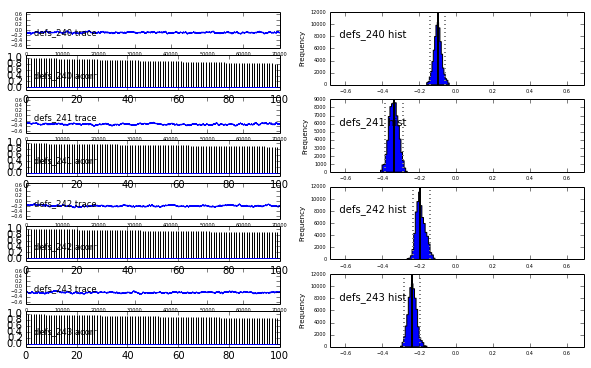

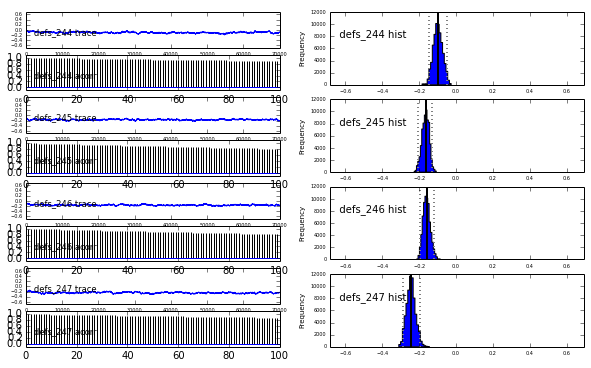

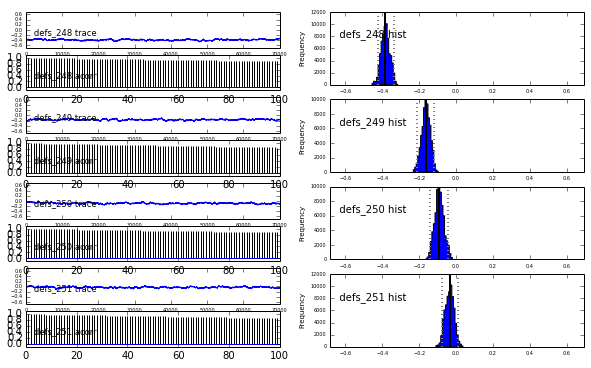

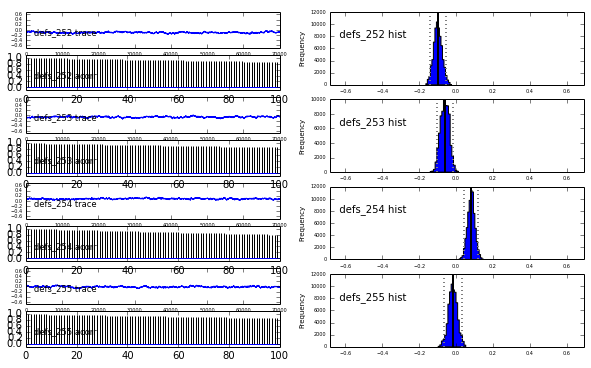

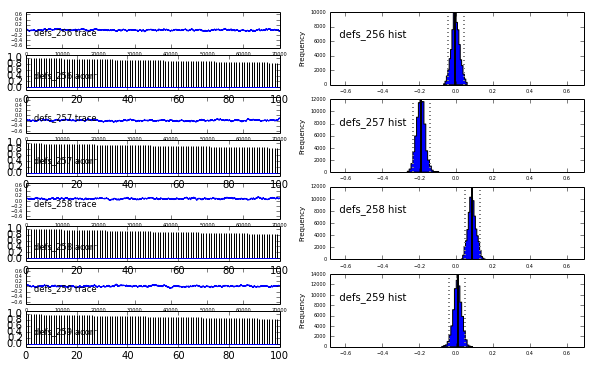

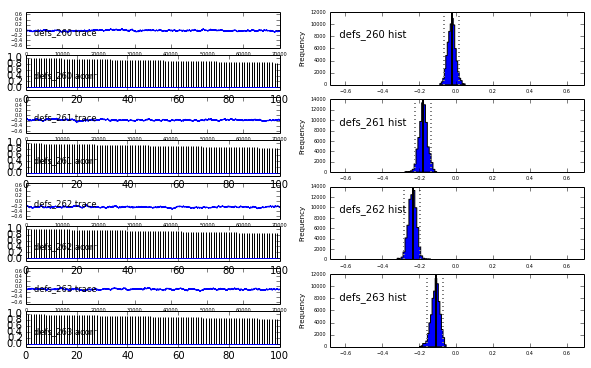

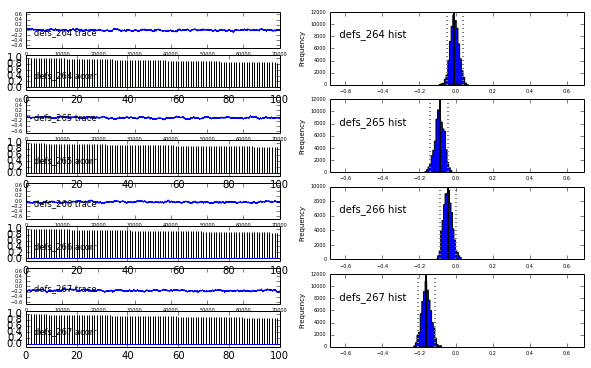

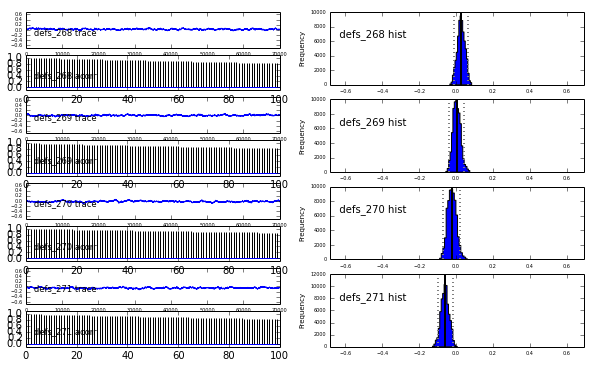

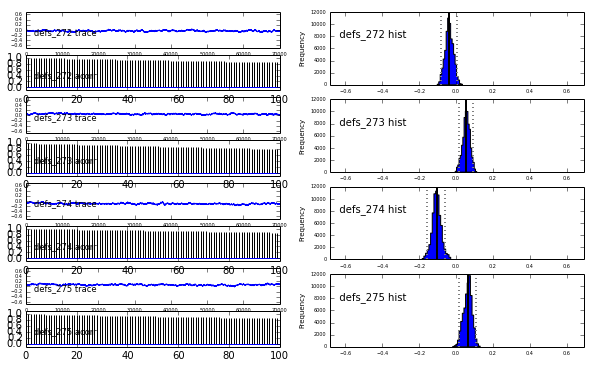

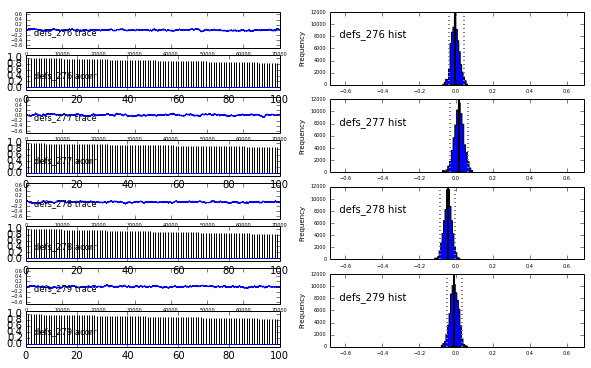

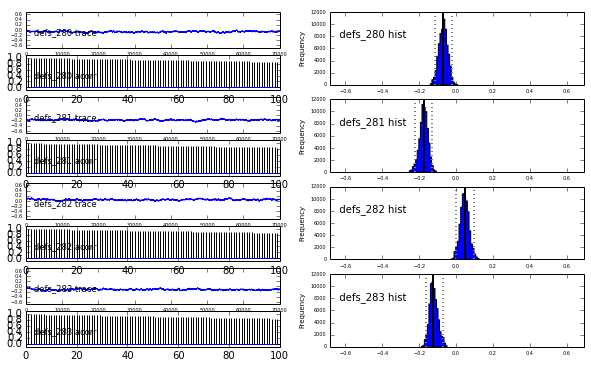

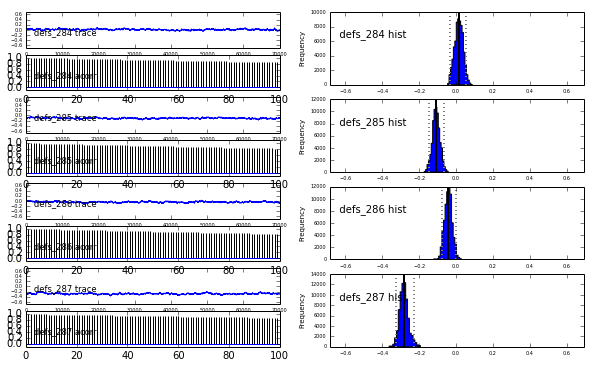

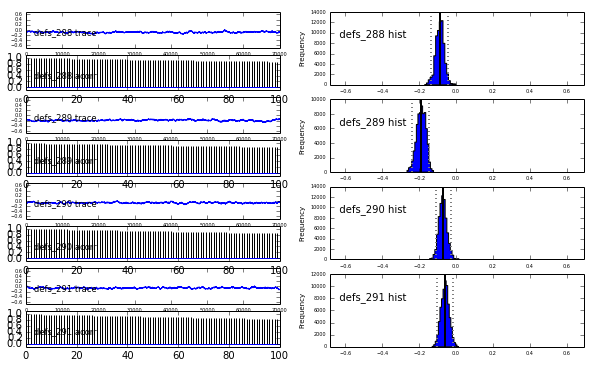

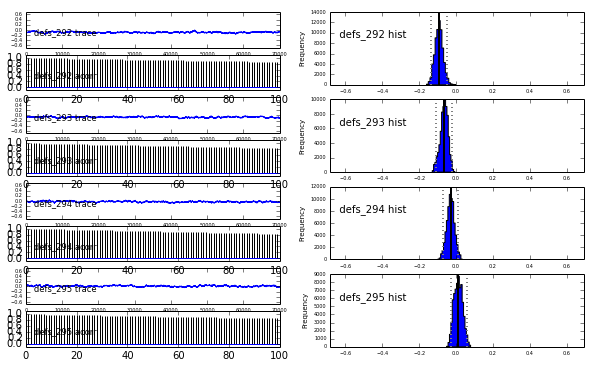

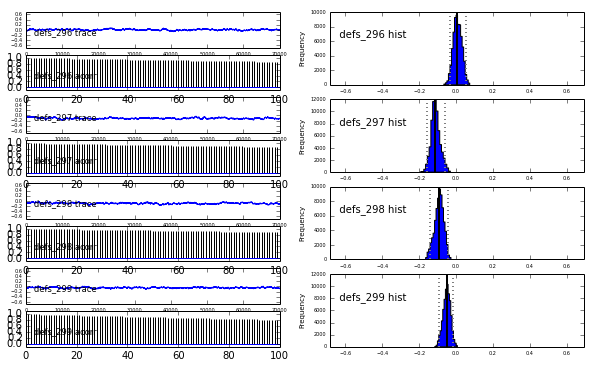

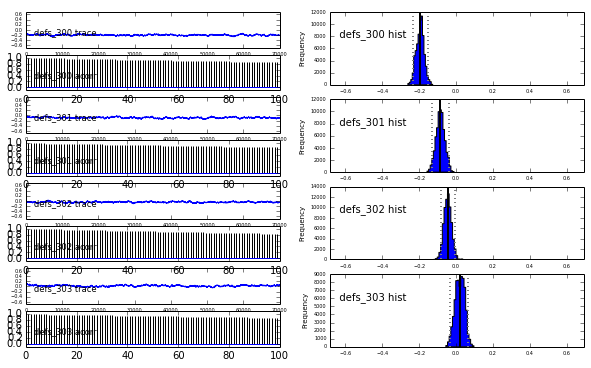

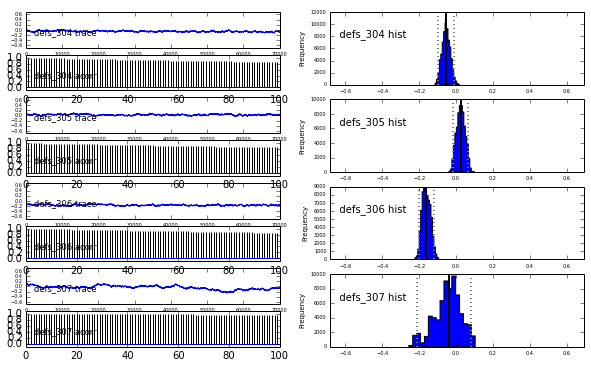

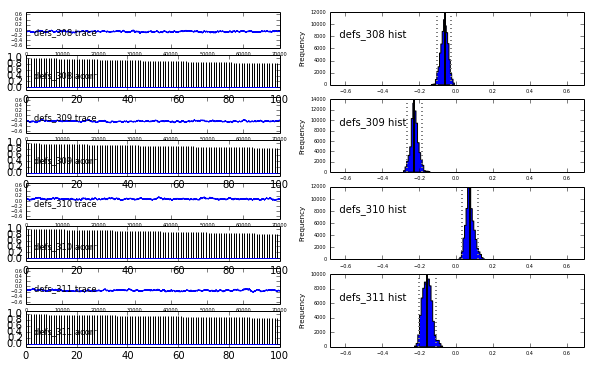

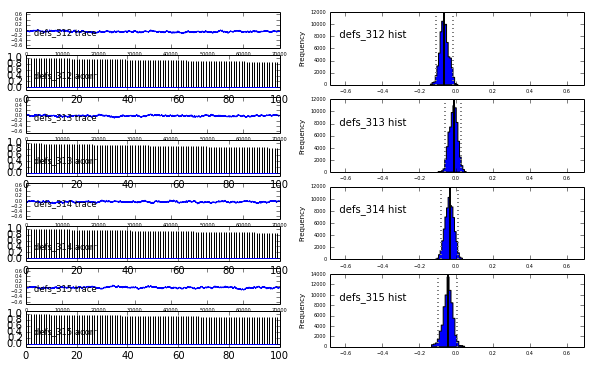

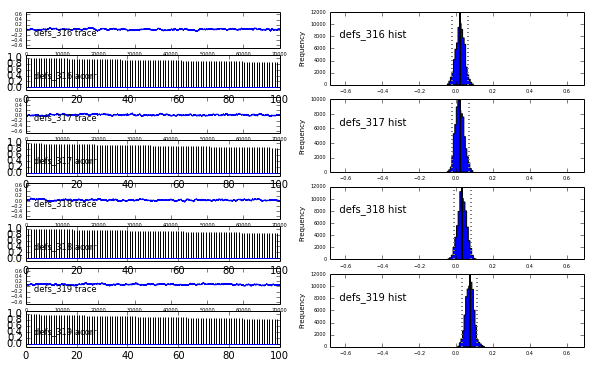

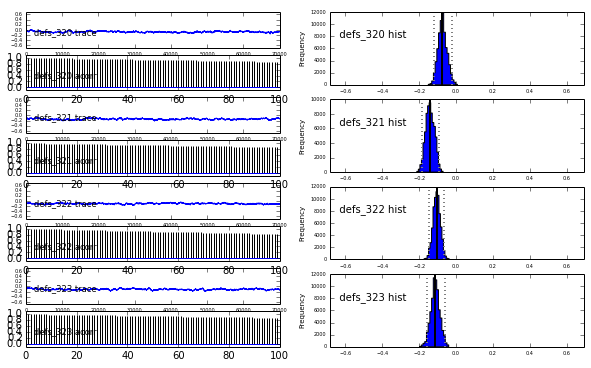

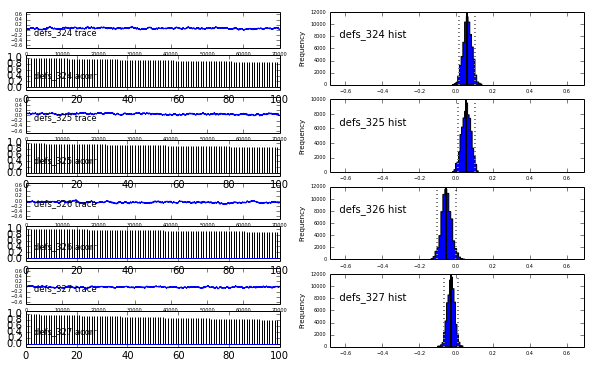

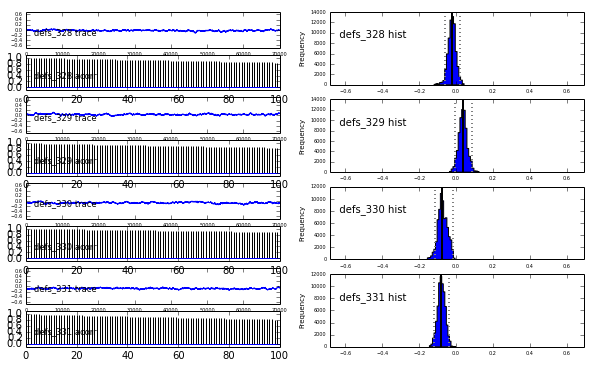

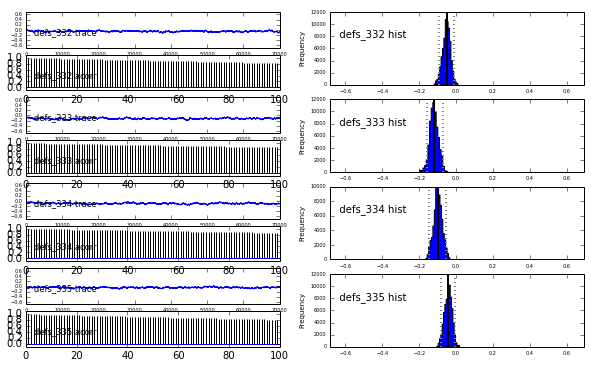

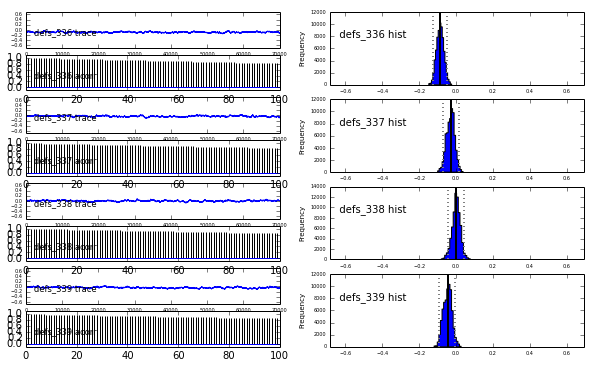

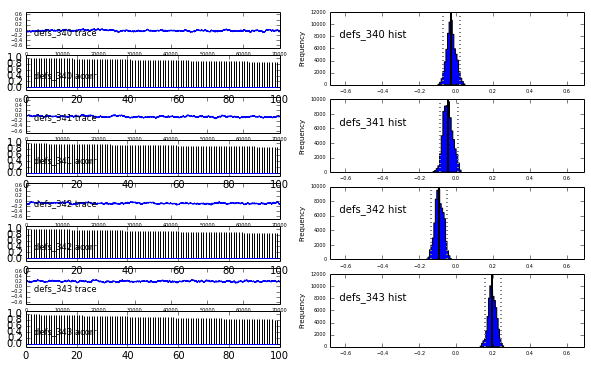

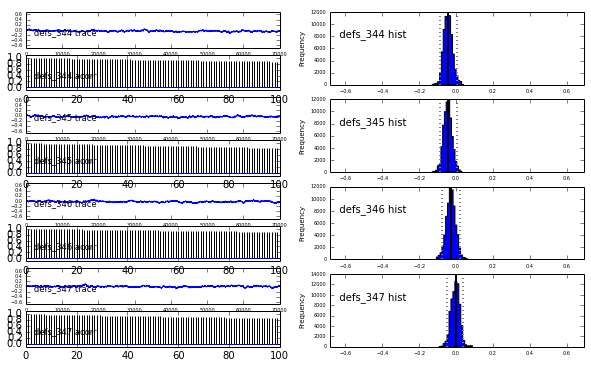

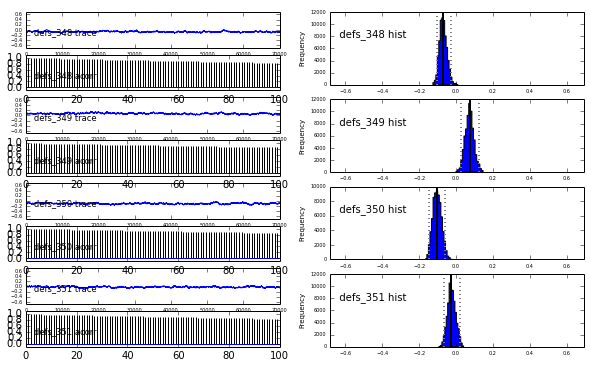

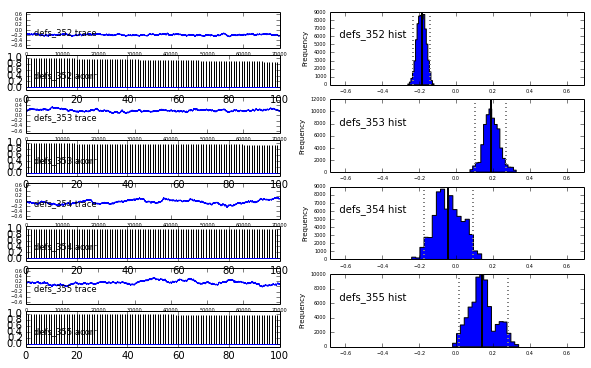

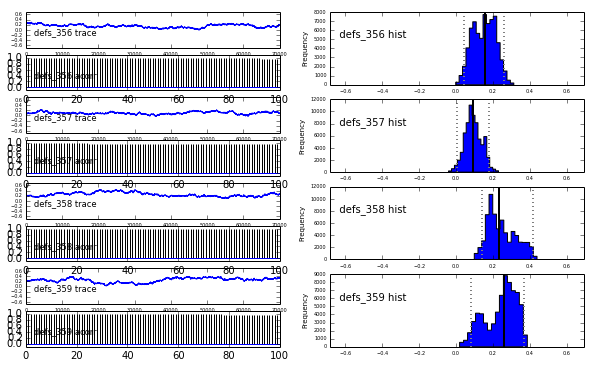

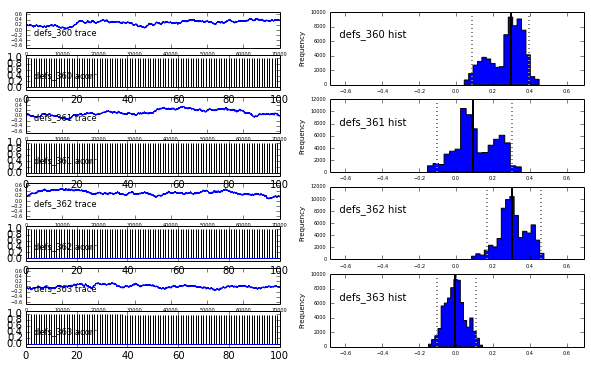

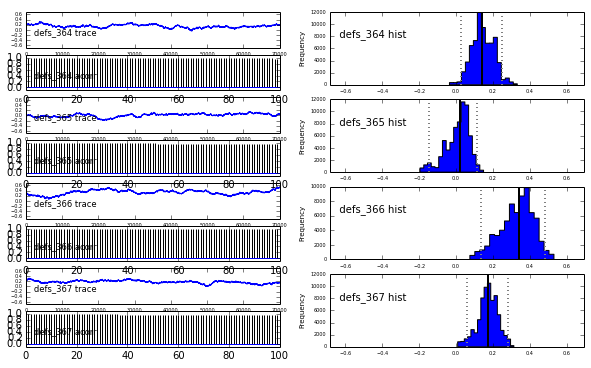

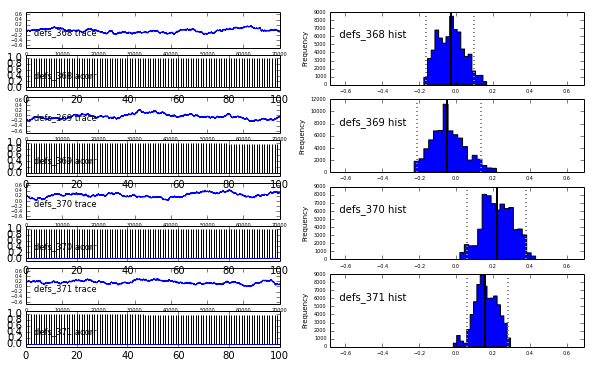

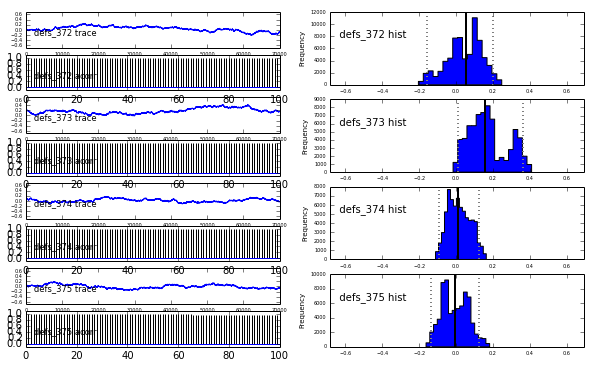

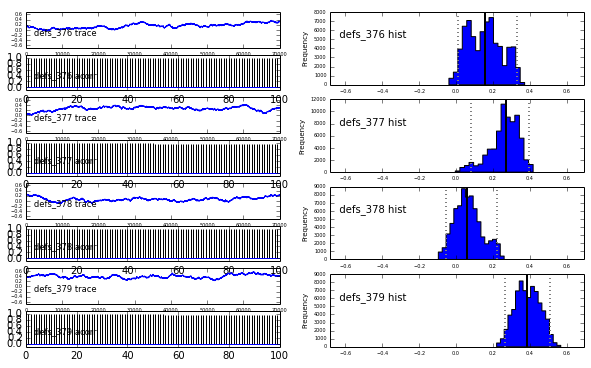

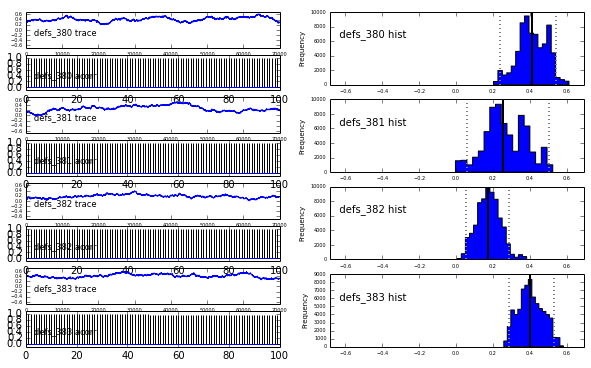

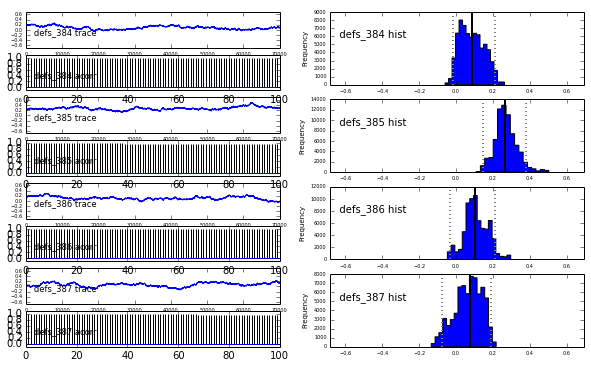

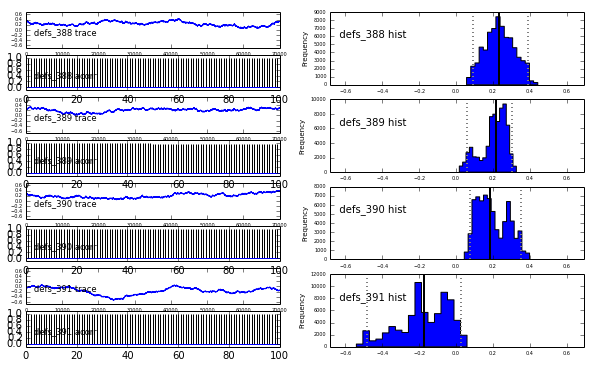

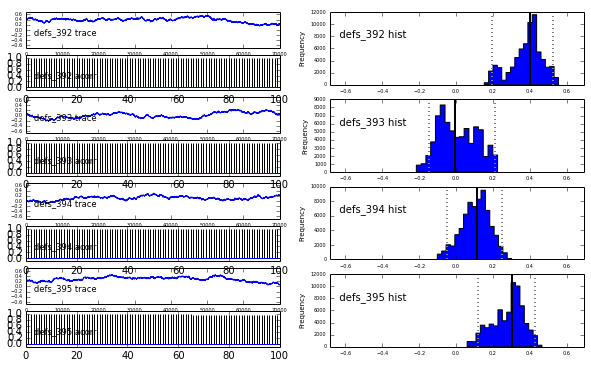

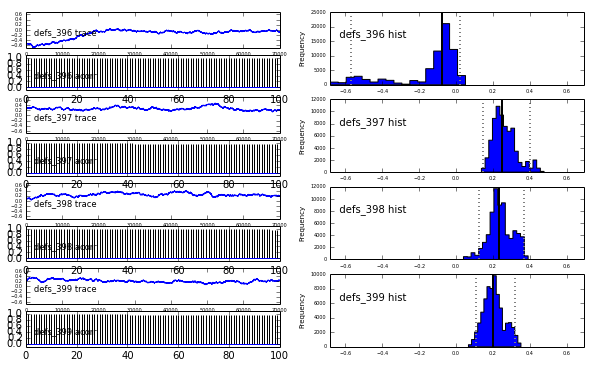

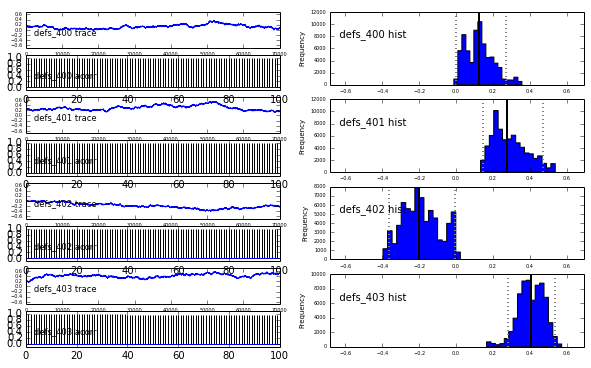

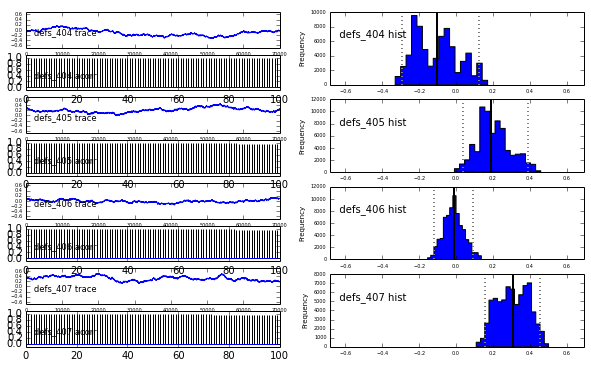

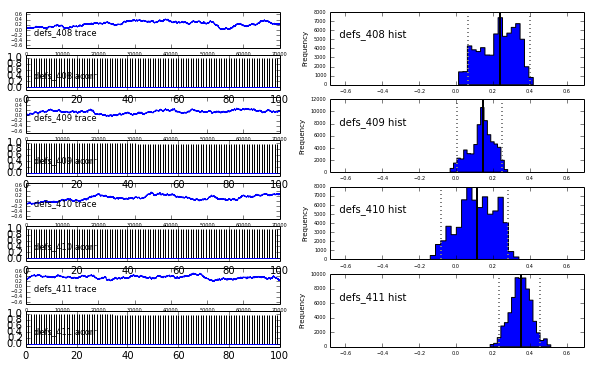

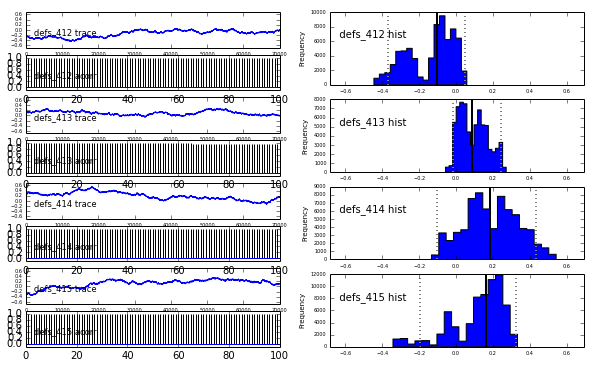

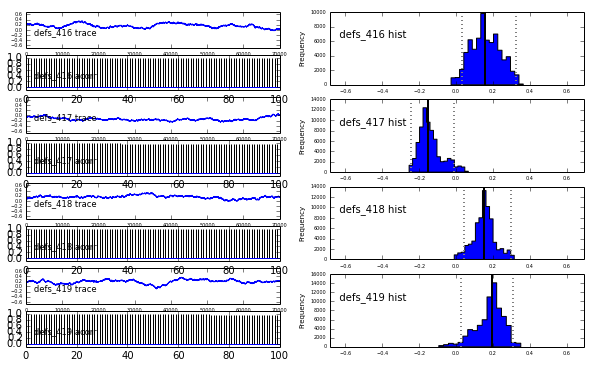

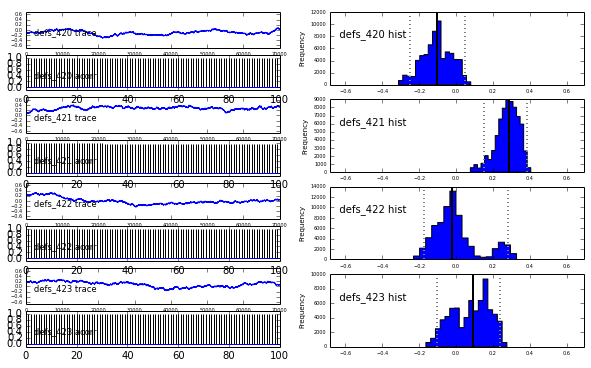

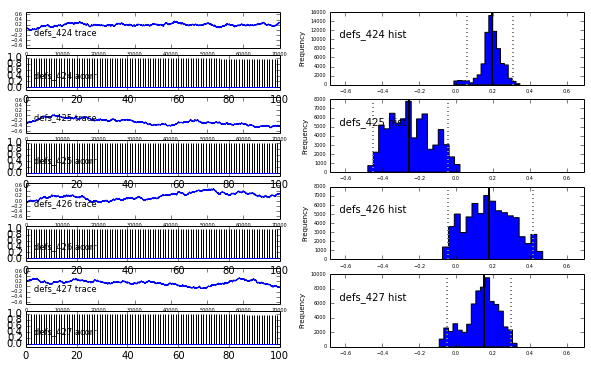

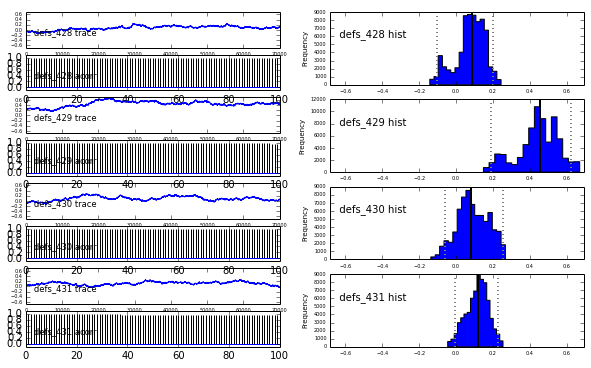

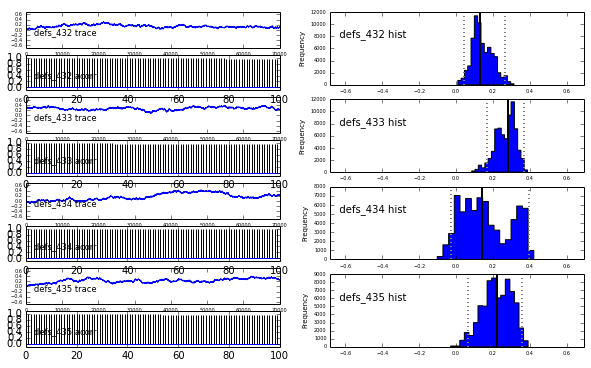

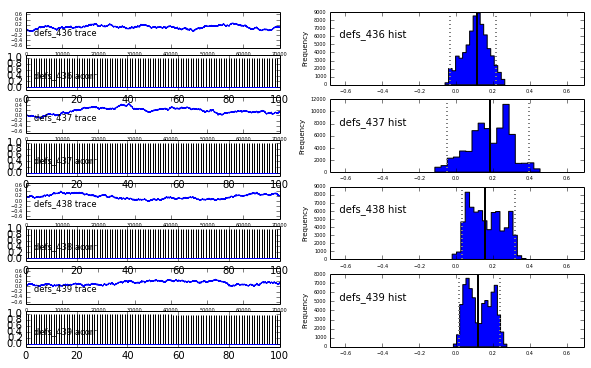

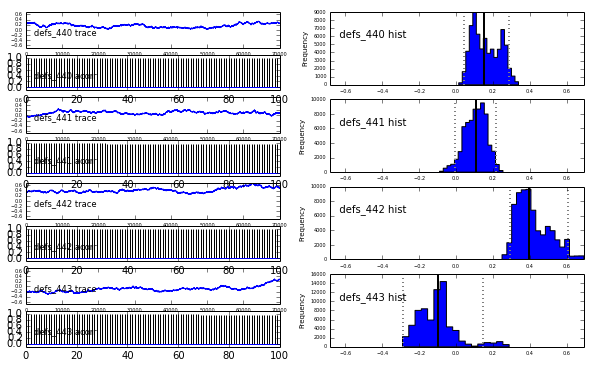

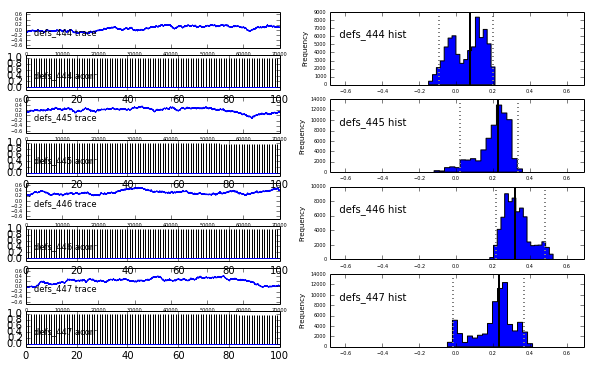

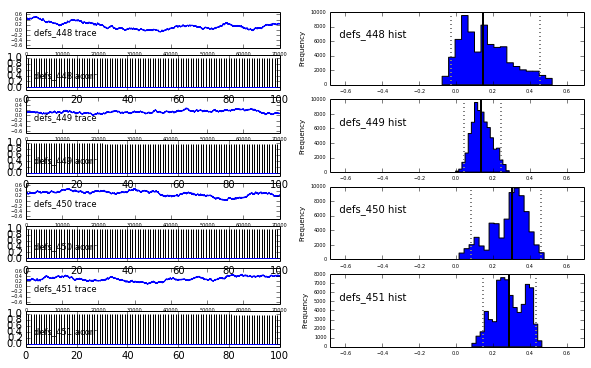

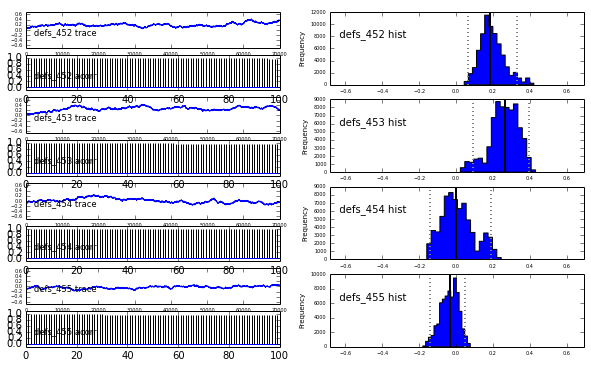

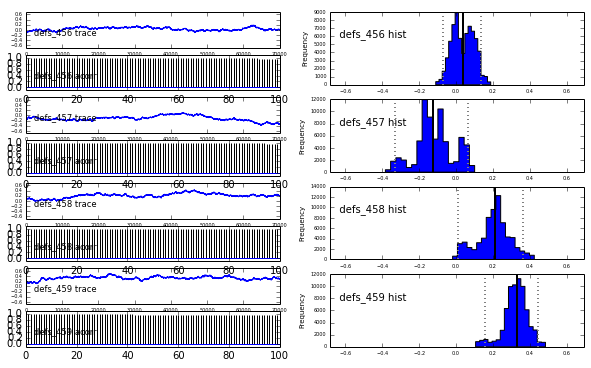

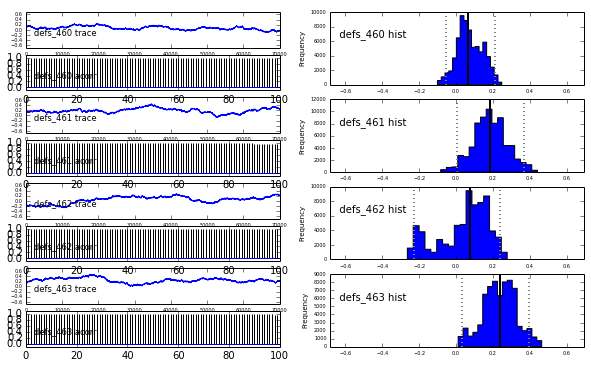

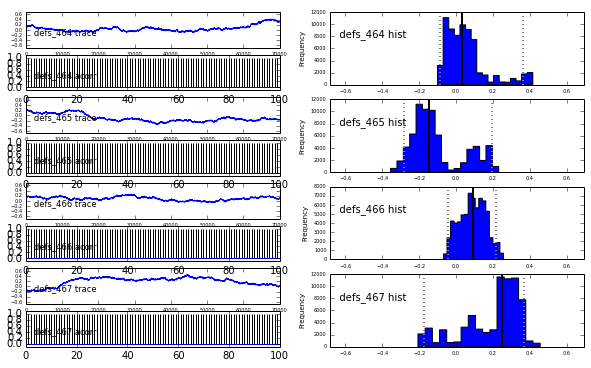

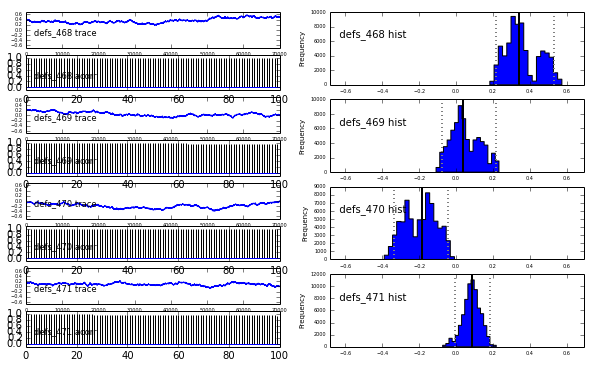

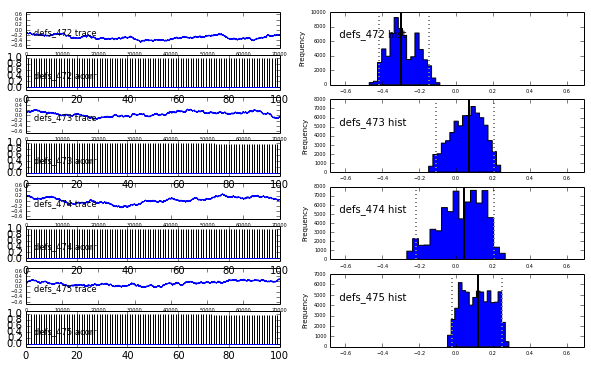

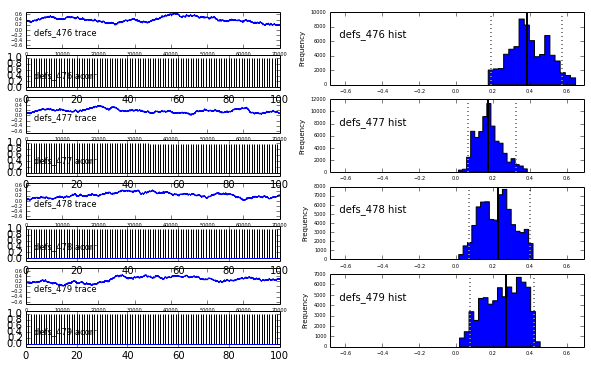

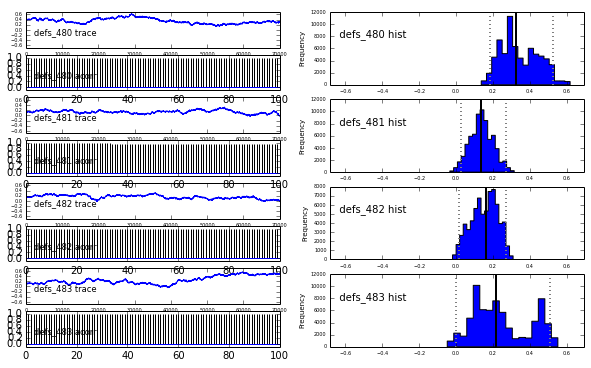

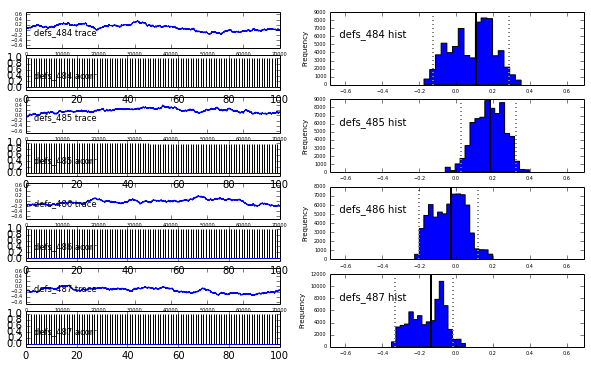

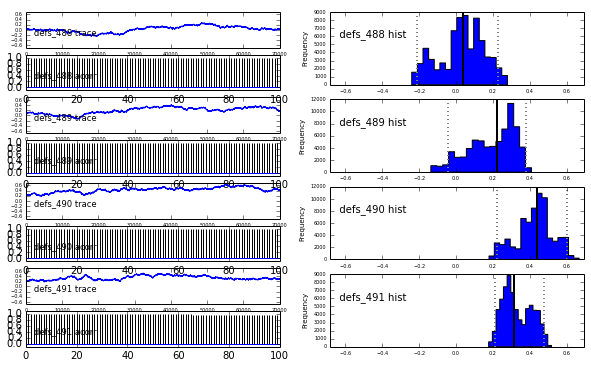

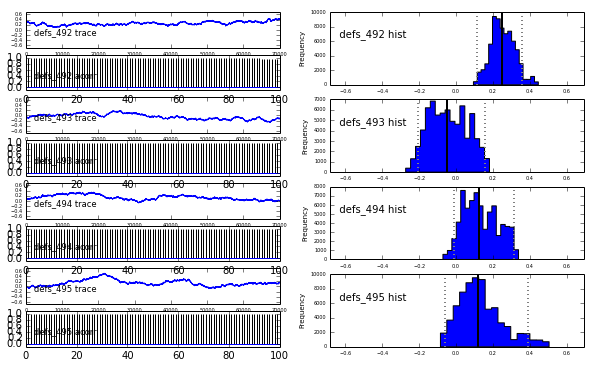

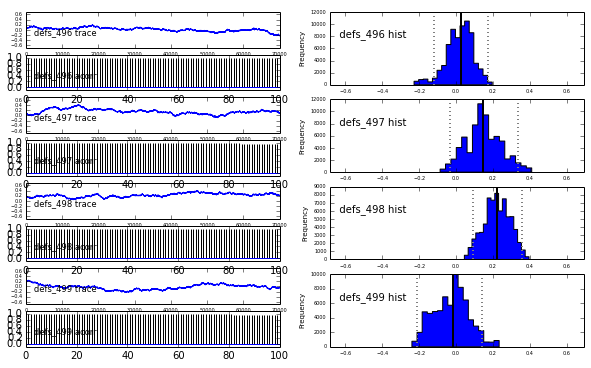

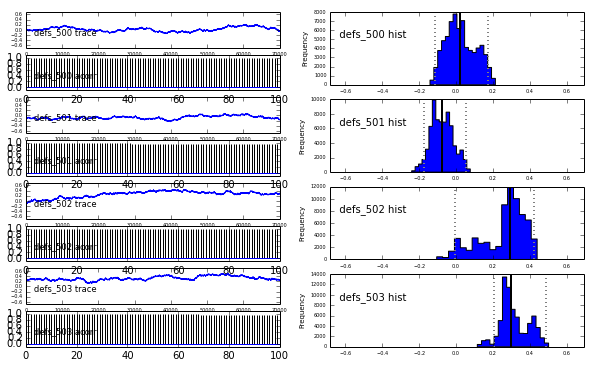

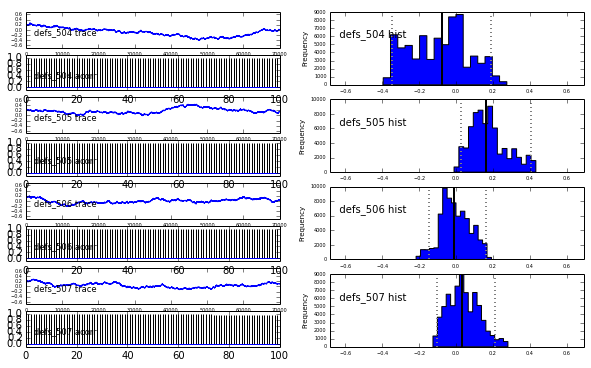

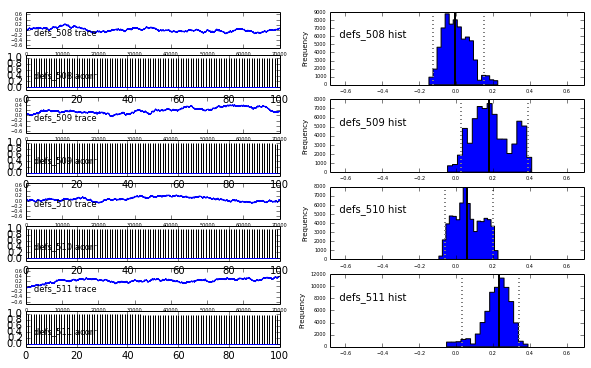

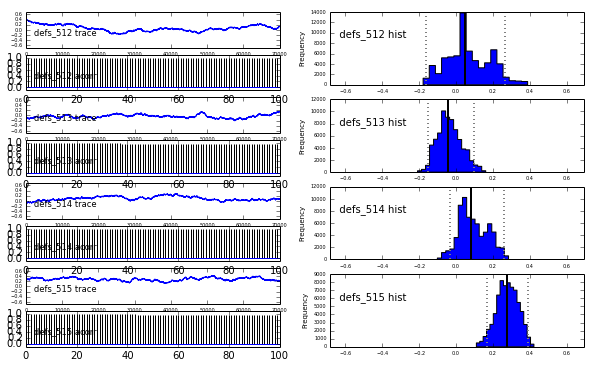

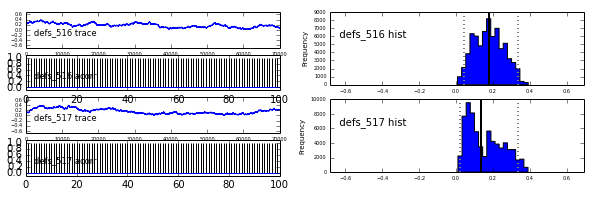

In [27]:
pymc.Matplot.plot(defs)

In [107]:
games.head()

dt 
 hteam_id 
 ateam_id 
 home_score 
 away_score 
 neutral 
 neutral_site 
 home_outcome 
 numot 
 game_id 
 opp_string 
 season 
 i_home 
 i_away 
 
 
 
 
 0 
 2014-11-14 
 86 
 649 
 69 
 67 
 False 
 None 
 True 
 0 
 3506808 
 Buffalo 
 2015 
 36 
 313 
 
 
 1 
 2014-11-17 
 295 
 649 
 82 
 77 
 False 
 None 
 True 
 0 
 3512407 
 Idaho 
 2015 
 144 
 313 
 
 
 2 
 2014-11-21 
 649 
 494 
 74 
 72 
 False 
 None 
 True 
 0 
 3519406 
 North Dakota 
 2015 
 313 
 237 
 
 
 3 
 2014-11-24 
 649 
 1012 
 87 
 42 
 False 
 None 
 True 
 0 
 3521726 
 Chadron St. 
 2015 
 313 
 407 
 
 
 4 
 2014-11-30 
 649 
 28755 
 58 
 71 
 True 
 Sioux Falls S.D. (Sanford Pentagon) 
 False 
 0 
 3545511 
 FGCU 
 2015 
 313 
 478

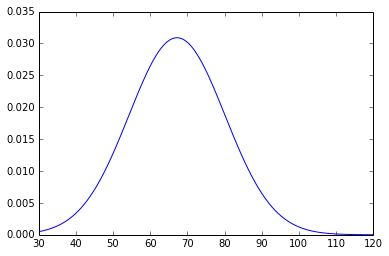

In [51]:
import matplotlib.mlab as mlab
mean = 67.2
variance = (1 / 0.006)**0.5
sigma = variance#**0.5
x = np.linspace(30,120,1000)
plt.plot(x,mlab.normpdf(x,mean,sigma))

(array([   11.,    20.,    76.,   120.,   243.,   496.,   612.,   741.,
         1013.,   744.,   623.,   577.,   285.,   179.,   114.,    36.,
           17.,    10.,     3.,     6.]),
 array([  26.  ,   30.35,   34.7 ,   39.05,   43.4 ,   47.75,   52.1 ,
          56.45,   60.8 ,   65.15,   69.5 ,   73.85,   78.2 ,   82.55,
          86.9 ,   91.25,   95.6 ,   99.95,  104.3 ,  108.65,  113.  ]),
 <a list of 20 Patch objects>)

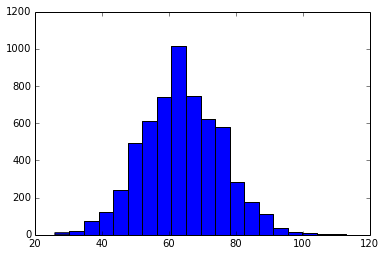

In [27]:
plt.hist(observed_away_goals, bins=20)

In [41]:
?pymc.Normal

In [127]:
(1/.1)**0.5

3.1622776601683795

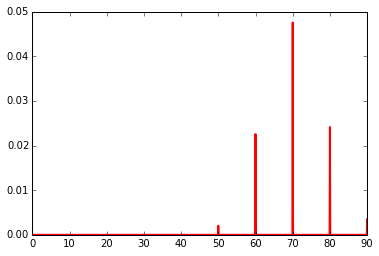

In [210]:
a=0.1
x = np.linspace(0, 90, 1000)
# plt.plot(x, scs.gamma.pdf(x, a, scale=0.1),'r-', lw=2, label='gamma pdf')
plt.plot(x, scs.poisson.pmf(x, 70.5),'r-', lw=2, label='gamma pdf')

In [214]:
mu = pymc.Uniform('mu', 60, 75, value=70.)
home_goals = pymc.Poisson('home_goals', 
                          mu=mu, 
                          value=observed_away_goals, 
                          observed=True)

model = pymc.Model([home_goals, mu])
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 sec

Plotting mu


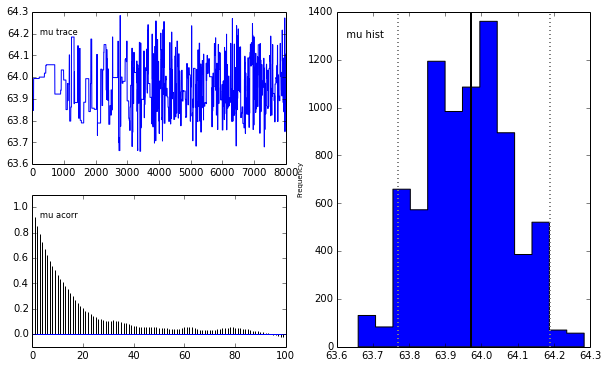

In [215]:
pymc.Matplot.plot(mu)

In [193]:
observed_home_goals

array([ 69.,  82.,  74., ...,  69.,  90.,  84.])

In [241]:
teams.head()

team_id 
 iteam 
 
 
 
 
 0 
 86 
 0 
 
 
 1 
 295 
 1 
 
 
 2 
 649 
 2 
 
 
 3 
 609 
 3 
 
 
 4 
 731 
 4

In [28]:
games.head()

dt 
 hteam_id 
 ateam_id 
 home_score 
 away_score 
 neutral 
 neutral_site 
 home_outcome 
 numot 
 game_id 
 opp_string 
 season 
 i_home 
 i_away 
 
 
 
 
 0 
 2014-11-14 
 86 
 649 
 69 
 67 
 False 
 None 
 True 
 0 
 3506808 
 Buffalo 
 2015 
 0 
 2 
 
 
 1 
 2014-11-17 
 295 
 649 
 82 
 77 
 False 
 None 
 True 
 0 
 3512407 
 Idaho 
 2015 
 1 
 2 
 
 
 2 
 2014-11-21 
 649 
 494 
 74 
 72 
 False 
 None 
 True 
 0 
 3519406 
 North Dakota 
 2015 
 2 
 24 
 
 
 3 
 2014-11-24 
 649 
 1012 
 87 
 42 
 False 
 None 
 True 
 0 
 3521726 
 Chadron St. 
 2015 
 2 
 354 
 
 
 4 
 2014-11-30 
 649 
 28755 
 58 
 71 
 True 
 Sioux Falls S.D. (Sanford Pentagon) 
 False 
 0 
 3545511 
 FGCU 
 2015 
 2 
 144

In [26]:
teams[teams.team_id == 306]

team_id 
 iteam 
 
 
 
 
 51 
 306 
 51